### <strong><font color=cornflowerblue>第一次作品：主成分分析 (PCA) 的應用與探討：標準化對降維與分群的影響</font></strong>
學號：411078064

姓名：謝意盛
<hr>

### <strong><font color=lightseagreen>作品目標</font></strong>：

本次作品將針對主成分分析（Principal Component Analysis，簡稱 PCA）進行探討，利用 3 筆資料進行實作，討論其在應用群組資料中的實用性，並觀察其對於資料變數的降維，直觀地去理解 PCA 的實際運行情況。實驗方向主要集中於標準化對於 PCA 結果的影響，以及 PCA 的結果是否會與資料原先劃分的群組（labels）相吻合。
具體步驟會先從匯入資料，觀察資料的基本屬性開始，然後分別繪製出變數間的相關係數矩陣熱圖（Heatmap）與盒鬚圖（Boxplot）。前者用於觀察變數間的線性相關程度，而後者則檢視變數的尺度範圍（Scaling）是否合理，作為是否進行標準化的判斷。
接著，為了體現標準化對於 PCA 的重要性，會同時執行未標準化與標準化的 PCA，並繪製 Scree Plot 與 Pareto Plot，比較兩者的特徵值分布，以及主成分變異量比例，初步觀察有無標準化的重要性，以及決定適當的主成分數量。
再來，先使用前兩個主成分來繪製散布圖（不加 labels），嘗試能否直觀看出資料的分群跡象，再來加入 labels 來驗證先前的猜想。若二維空間無法清楚區分群組，則可嘗試引入第三主成分來繪製三維散布圖，觀察在三維空間裡能否更清楚地區分群組。
最後，比較原變數的相關係數矩陣與 PCA 的特徵向量權重，分析兩者之間是否存在關聯，探討變數間的相關性如何影響 PCA 結果，加深對 PCA 的理解。

<hr>

#### <strong><font color=indianred>參考資料</font></strong>：

1. [汪群超 Chun-Chao Wang 老師講義](https://ntpuccw.blog/python-in-learning/sml-lesson-5-%e4%b8%bb%e6%88%90%e5%88%86%e5%88%86%e6%9e%90%e7%9a%84%e5%8e%9f%e7%90%86%e8%88%87%e5%af%a6%e9%a9%97/)

<hr>

#### <strong><font color=indianred>載入套件</font></strong>：

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 第三題資料
from sklearn.datasets import load_breast_cancer

<hr>
<hr>

### **<font color=cornflowerblue>第 1 題：</font>**  

本題使用來自義大利某地區三家紅酒製造商的資料集，該資料包含 **178** 支紅酒的 **13 種化學成分**。

資料來源：

1. 可下載：[wine.xlsx](https://ntpuccw.blog/wp-content/uploads/2023/02/wine.xlsx)
2. 使用 `from sklearn.datasets import load_wine`。

##### (1) 匯入資料，觀察資料的基本屬性。

In [2]:
# 路徑
path = r"C:\Users\Sheng\Documents\NTPU_Bachelor\Year_4\Y4_Sem_2\ShallowML\ClassData"
# 讀取資料
df_wine = pd.read_excel(path + r'\Wine.xlsx')
df_wine.head()
# 取出反應變數 y
y = df_wine.iloc[:, -1].values
# 移除最後一欄
df_wine1 = df_wine.iloc[:, :-1]

# 顯示資料特性
# df.info()
print('【樣本數】:', df_wine1.shape[0])
print('【欄位數】:', df_wine1.shape[1])
print('【群組數】:', len(np.unique(y)))
# 動態生成每群樣本數
unique_groups, group_counts = np.unique(y, return_counts=True)
group_info = ', '.join([f'{group}: {count}' for group, count in zip(unique_groups, group_counts)])
print(f'【每群樣本數】: {group_info}')
display(df_wine1.head())

【樣本數】: 178
【欄位數】: 13
【群組數】: 3
【每群樣本數】: 1: 59, 2: 71, 3: 48


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


<hr>

##### (2) 利用 `seaborn` 套件裡的 `heatmap` 指令繪製出變數間的相關係數圖，以觀察變數間是否存在相關性。

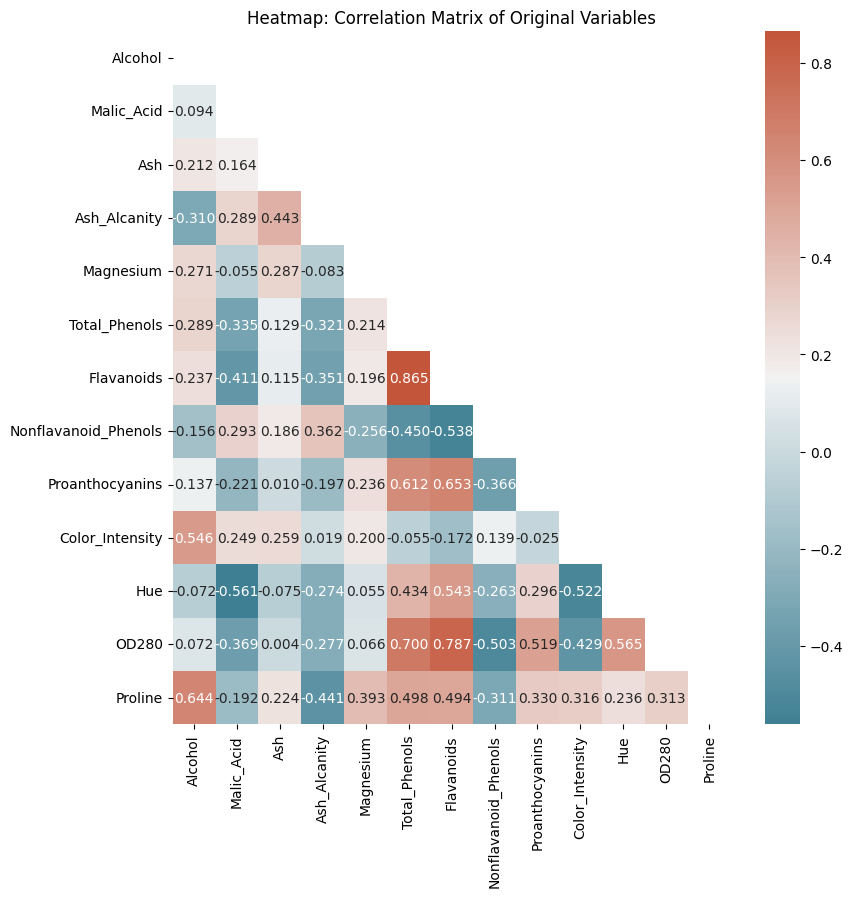

In [125]:
# Plot the correlation matrix
plt.style.use('default')
plt.figure(figsize = (9, 9))
# 計算相關係數
R = df_wine1.corr()
# np.ones_like(R, dtype = bool): 生成一個和 R 一樣大小的矩陣，元素全為 True
# np.triu(): 上三角矩陣（np.tril 則是下三角矩陣）
mask = np.triu(np.ones_like(R, dtype = bool)) # diagonal mask 
# annot = True: 在 heatmap 上標註相關係數
# mask: 隱藏上三角（或下三角）
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(R, annot = True, mask = mask, cmap = cmap, fmt = ".3f")
plt.title('Heatmap: Correlation Matrix of Original Variables')
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 上圖呈現的是變數間的相關係數圖。由於相關係數矩陣為對稱矩陣（Symmetric Matrix），因此僅顯示其下三角矩陣（Lower Triangular Matrix）。  

- 從圖中可見，紅色越深代表變數間的正相關性越高，而藍色越深則代表負相關性越高。例如，**Flavanoids** 與 **Total_Phenols** 及 **OD280** 之間呈現高度正相關，相關係數皆大於 0.7；而與 **Nonflavanoid_Phenols** 及 **Malic_Acid** 則呈現高度負相關，相關係數皆小於 -0.4。  

- 另一個例子是 **Color_Intensity** 與 **Alcohol** 及 **Proline** 之間存在高度正相關，相關係數皆大於 0.3，而與 **Hue** 及 **OD280** 則呈現高度負相關，相關係數皆小於 -0.4。  

- 從相關係數矩陣的觀察結果來看，部分變數之間確實存在較強的相關性，因此可考慮使用主成分分析（PCA）進行降維，以減少變數間的多重共線性並提升分析的效能。

<hr>

##### (3) 繪製一張含有每種化學成分（變數）的盒鬚圖（Boxplot），觀察每個變數的數值範圍（Scaling），以作為是否需要標準化的參考。同時，再繪製一張標準化後的盒鬚圖，並與原始資料進行比較。

1）將資料進行標準化

In [3]:
# 將資料進行標準化
columns = df_wine1.columns
scaler = StandardScaler()  # create a StandardScaler object
X_std = scaler.fit_transform(df_wine1)  # standardize the data
df_X_std = pd.DataFrame(X_std, columns=columns)

2）繪製 boxplot

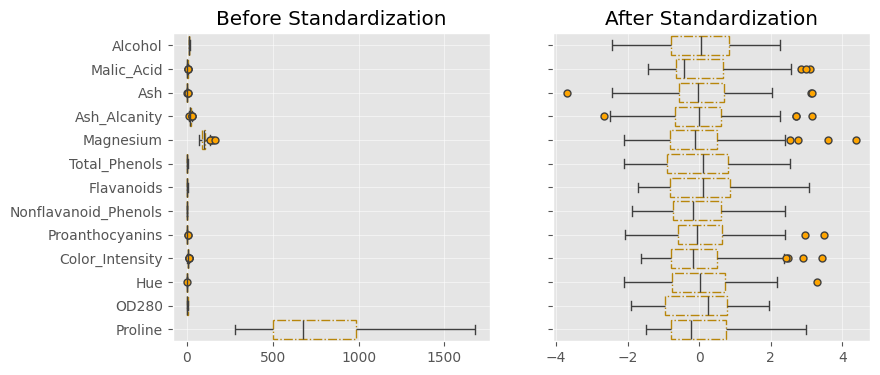

In [7]:
# 繪製 boxplot
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
boxprops = dict(linestyle='-.', linewidth=1, facecolor='none', edgecolor='darkgoldenrod')
flierprops = dict(marker='o', markerfacecolor='orange', markersize=5, linestyle='none')

# 未標準化
sns.boxplot(data=df_wine1, ax=ax[0], orient='h', boxprops=boxprops, flierprops=flierprops)
ax[0].grid(True, alpha=0.5)
ax[0].set_title('Before Standardization')

# 標準化
sns.boxplot(data=df_X_std, ax=ax[1], orient='h', boxprops=boxprops, flierprops=flierprops)
ax[1].grid(True, alpha=0.5)
ax[1].set_title('After Standardization')

plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 左圖顯示的是原始資料中各化學成分的盒鬚圖，而右圖則是標準化後的盒鬚圖。  

- 從左圖可以明顯看出，各化學成分的數值範圍並不一致，尤其是 **Proline**，其數值範圍遠高於其他變數，導致整體資料的 scaling 被拉長。因此，為了避免 **Proline** 在後續分析中對結果產生過大影響，應對資料進行標準化，以降低潛在誤差。  

- 標準化後的右圖顯示，各化學成分的數值範圍趨於一致，使後續分析更加穩定，避免因資料 scaling 差異而產生誤差。

<hr>

##### (4) 對原始資料與標準化後的資料分別進行主成分分析（PCA），並繪製 Scree Plot（顯示特徵值由大到小的分布）以及 Pareto Plot（顯示每個主成分解釋的變異量比例及其累積變異量比例），觀察標準化是否會影響主成分的分析結果。

1）進行 PCA

In [8]:
# PCA
# 未標準化的資料
pca = PCA()  # create a PCA object
X_pca = pca.fit(df_wine1)  # apply PCA to the standardized data
Z = pca.transform(df_wine1)  # get the new data matrix Z
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

# 標準化後的資料
pca_std = PCA()  # create a PCA object
X_pca_std = pca_std.fit(X_std)  # apply PCA to the standardized data
Z_std = pca_std.transform(X_std)  # get the new data matrix Z
eigenvalues_std = pca_std.explained_variance_
eigenvectors_std = pca_std.components_

2）繪製 Scree Plot 和 Pareto Plot

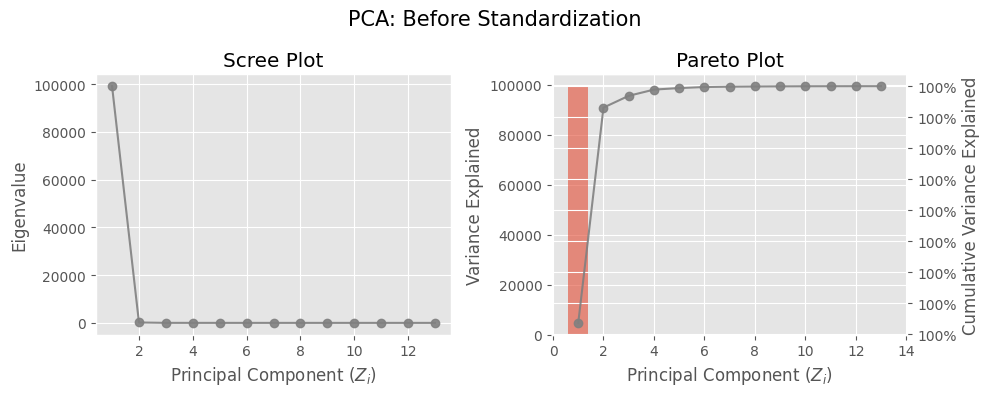

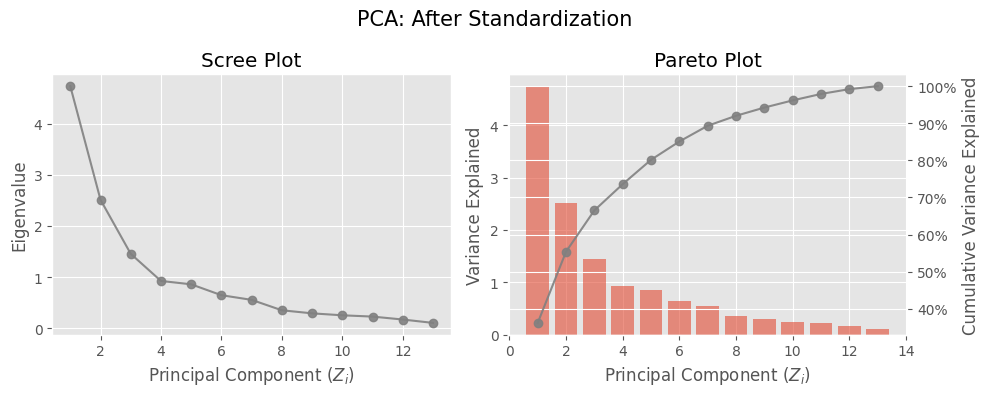

In [9]:
# 繪製 scree plot 和 pareto plot
plt.style.use('ggplot')

def plots(eigenvalues, title):
    # 計算主成分數量
    pca_range = np.arange(1, len(eigenvalues) + 1)
    # 計算解釋變異量
    cum_var_exp = np.cumsum(eigenvalues / eigenvalues.sum()) * 100

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # Scree Plot
    ax[0].plot(pca_range, eigenvalues, 'o-', alpha=0.9, color='gray')
    ax[0].set_title('Scree Plot')
    ax[0].set_xlabel('Principal Component ($Z_i$)')
    ax[0].set_ylabel('Eigenvalue')

    # Pareto Plot
    ax2 = ax[1].twinx()  # 創建共享 x 軸的第二個 y 軸
    ax[1].bar(pca_range, eigenvalues, alpha=0.6, align='center', label='Individual explained variance')
    ax[1].set_title('Pareto Plot')
    ax[1].set_xlabel('Principal Component ($Z_i$)')
    ax[1].set_ylabel('Variance Explained')
    if title == 'PCA: Before Standardise':
        # 使用 FuncFormatter 來格式化 y 軸標籤，例如1e2
        ax[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0e}'.format(x)))
    # 畫出累積解釋變異量，用百分比表示
    ax2.plot(pca_range, cum_var_exp, 'o-', alpha=0.9, color='gray')
    ax2.set_ylabel('Cumulative Variance Explained')
    
    if title == 'PCA: Before Standardise':
        # 使用 FuncFormatter 來格式化 y 軸標籤
        ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1f}%'.format(y)))
    else:
        ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()

# 未標準化
plots(eigenvalues, 'PCA: Before Standardization')
# 標準化
plots(eigenvalues_std, 'PCA: After Standardization')

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 上圖為原始資料進行 PCA 後的結果，其中 **Scree Plot**（左上）顯示特徵值的分布，**Pareto Plot**（右上）則顯示各主成分的變異量比例與累積變異量比例；下圖則為標準化後資料進行 PCA 的對應結果，分別為 **Scree Plot**（左下）與 **Pareto Plot**（右下）。  

- 從上圖可以看出，**Scree Plot** 中第一與第二主成分的特徵值差距顯著，而 **Pareto Plot** 顯示第一主成分解釋的變異量比例遠高於其他主成分，導致變異分配極不均衡，說明未標準化的資料會影響 PCA 的結果，使得部分主成分的影響被放大或縮小。  

- 下圖則顯示標準化後的 PCA 分析結果較為合理，表明標準化後的 PCA 具有較佳的解釋性。在 **Scree Plot** 中，前三個主成分的特徵值變化較為陡峭，而從第四主成分開始趨於平緩；**Pareto Plot** 則顯示前三主成分的累積變異量比例已接近 70%，表示這三個主成分已能解釋大部分資料的變異。因此，可判斷該資料取前三個主成分即可有效代表原始資料的結構，同時大幅降低維度，減少資訊流失並提升後續分析的效率。

<hr>

##### (5) 資料中的每支酒都有標籤（df_wine 中的 **Customer_Segment**），表示其來自的酒莊。現在假設不考慮此標籤，先利用主成分分析（PCA）擷取前兩個主成分（$Z_1$ 和 $Z_2$），並繪製其散布圖，觀察該散布圖是否能夠顯示出三個明顯的群組。請注意：資料是否經過標準化可能會影響結果，試著比較標準化與非標準化情況下的差異。

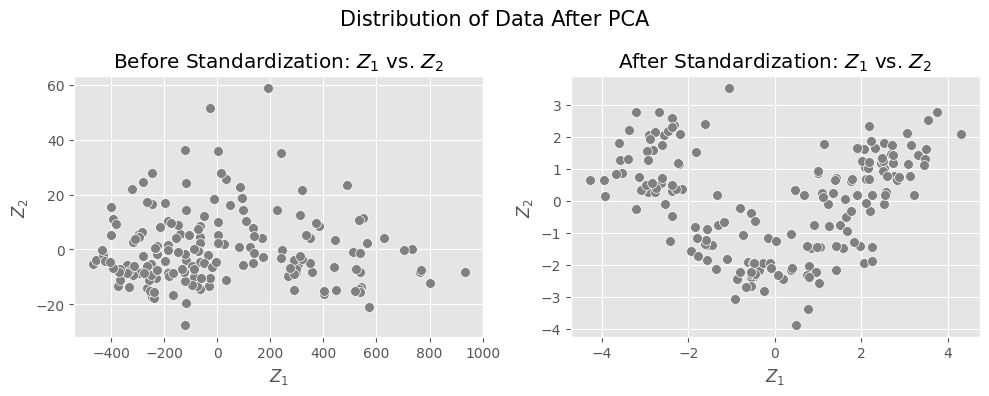

In [10]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(Z[:, 0], Z[:, 1], edgecolors='w', color='gray', s=50)
ax[0].set_xlabel('$Z_1$')
ax[0].set_ylabel('$Z_2$')
ax[0].set_title('Before Standardization: $Z_1$ vs. $Z_2$')

ax[1].scatter(Z_std[:, 0], Z_std[:, 1], edgecolors='w', color='gray', s=50)
ax[1].set_xlabel('$Z_1$')
ax[1].set_ylabel('$Z_2$')
ax[1].set_title('After Standardization: $Z_1$ vs. $Z_2$')

plt.suptitle('Distribution of Data After PCA', fontsize=15)
plt.tight_layout()
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 左圖為未標準化資料的前兩個主成分所繪製的散佈圖。可以看出，資料點之間的分布並無明顯區隔，無法直接劃分出群組，顯示未標準化的資料可能會影響 PCA 的判斷。  

- 右圖則為標準化後的前兩個主成分散佈圖。與左圖相比，資料點呈現出較明顯的分布模式，整體趨勢呈 **V** 字形，可清楚觀察並劃分出三個群組，說明標準化確實有助於 PCA 結果的判讀。

<hr>

##### (6) 根據每筆資料的標籤（已在第 1 小題中存入 **y** 變數），為散布圖上的資料點填上對應的顏色，並觀察其分布是否與前一小題的判斷相符。

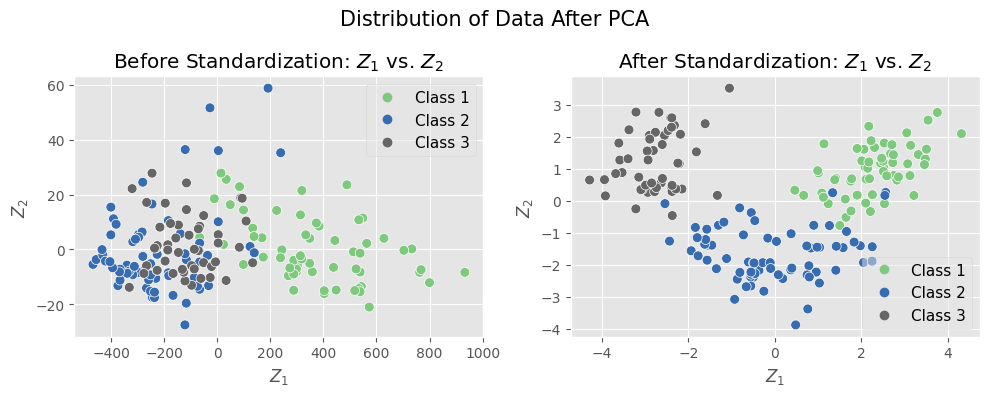

In [11]:
plt.style.use('ggplot')
# 獲取唯一的類別
unique_classes = np.unique(y)

# 創建顏色映射
base_cmap = plt.colormaps['Accent']
cmap = ListedColormap(base_cmap(np.linspace(0, 1, len(unique_classes))))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Before Standardise
scatters = ax[0].scatter(Z[:, 0], Z[:, 1], c=y, edgecolors='w', cmap=cmap, s=50)
ax[0].set_xlabel('$Z_1$')
ax[0].set_ylabel('$Z_2$')
ax[0].set_title('Before Standardization: $Z_1$ vs. $Z_2$')

# 查出 scatters 使用的顏色和對應的類別
colors = cmap(np.linspace(0, 1, len(unique_classes)))
labels = [f'Class {cls}' for cls in unique_classes]

# 創建圖例項目
legend_patches = [mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None', markersize=6, 
                                label=labels[i]) for i in range(len(unique_classes))]

# 添加圖例
legend = ax[0].legend(handles=legend_patches, loc='upper right', fontsize=11)
legend.get_frame().set_alpha(0.5)  # 設置圖例框的透明度

# After Standardise
scatters_std = ax[1].scatter(Z_std[:, 0], Z_std[:, 1], c=y, edgecolors='w', cmap=cmap, s=50)
ax[1].set_xlabel('$Z_1$')
ax[1].set_ylabel('$Z_2$')
ax[1].set_title('After Standardization: $Z_1$ vs. $Z_2$')

# 查出 scatters_std 使用的顏色和對應的類別
colors_std = cmap(np.linspace(0, 1, len(unique_classes)))
labels_std = [f'Class {cls}' for cls in unique_classes]

# 創建圖例項目
legend_patches_std = [mlines.Line2D([], [], color=colors_std[i], marker='o', linestyle='None', markersize=6, 
                                    label=labels_std[i]) for i in range(len(unique_classes))]

# 添加圖例
legend = ax[1].legend(handles=legend_patches_std, loc='lower right', fontsize=11)
legend.get_frame().set_alpha(0.5)  # 設置圖例框的透明度

plt.suptitle('Distribution of Data After PCA', fontsize=15)
plt.tight_layout()
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 左圖為未標準化資料的前兩個主成分散布圖。加入標籤後可以更直觀地觀察到，資料點之間並未形成明確的分群，即使進行了 PCA，仍無法有效區分群組，這再次說明標準化對 PCA 的重要性。  

- 右圖為標準化資料的前兩個主成分散布圖。與左圖相比，加入標籤後可以明顯看出資料點已被清楚劃分為三個群組，進一步證明標準化有助於 PCA 在群組辨識上的效果。

- 綜合第 3、4、5、6 小題的結果，可以明顯看出標準化與否對 PCA 影響重大。因此，在進行 PCA 之前，應先檢視資料的數值範圍（scaling），判斷是否需要標準化，以避免後續分析產生誤差。

<hr>

##### (7) 當採用三個主成分時，可繪製三維散布圖，以觀察群組的區分效果是否更佳。請嘗試旋轉視角，以獲得最佳辨識效果，並檢視在三維空間中，資料點是否能夠更清楚地分群。

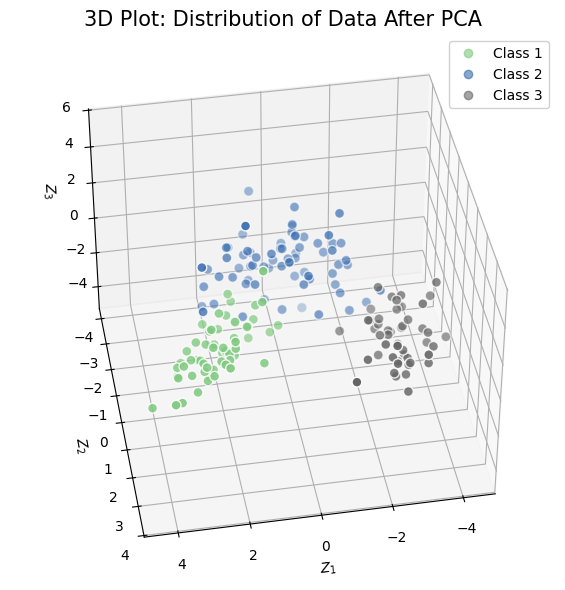

In [88]:
# 獲取唯一的類別
unique_classes = np.unique(y)

# 創建顏色映射
base_cmap = plt.colormaps['Accent']
cmap = ListedColormap(base_cmap(np.linspace(0, 1, len(unique_classes))))

# 改畫立體圖，要利用三個主成分
plt.style.use('default')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(Z_std[:, 0], Z_std[:, 1], Z_std[:, 2], c=y, edgecolors='w', cmap=cmap, s=50)
ax.set_xlabel('$Z_1$')
ax.set_ylabel('$Z_2$')
ax.set_zlabel('$Z_3$')
ax.set_title('3D Plot: Distribution of Data After PCA', fontsize=15)

# 調整觀察角度
ax.view_init(elev=40, azim=80)  # 例如，仰角 40 度，方位角 80 度

# 創建圖例項目
legend_elements, _ = sc.legend_elements(prop="colors", alpha=0.6)
labels = [f'Class {cls}' for cls in unique_classes]

# 添加圖例
legend = ax.legend(handles=legend_elements, labels=labels, loc='upper right', fontsize=10)
legend.get_frame().set_alpha(0.9)  # 設置圖例框的透明度

plt.tight_layout()
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 上圖為標準化後資料的前三個主成分所繪製的三維散布圖（3D Scatter Plot）。從圖中可以清楚看出，資料點在三維空間中已能有效區分，說明僅使用前三個主成分即可完整呈現資料的分布情況，進一步驗證了第 4 小題的判斷。

- 這證明在更高維度的空間中，可以更清晰地觀察資料點的分布，從而減少資訊遺失，提升對資料結構的辨識能力。

<hr>

##### (8) 觀察並判斷原變數 $X_i$ 與主成分 $Z_i$ 之間的關係： 

主成分 $Z_1$ 和 $Z_2$ 是由原始變數 $X_i$ 的線性組合所形成的新變數。我們可以透過前兩個特徵向量（eigenvectors）的係數，來分析各原變數對於這兩個主成分的貢獻程度，判斷哪些變數影響較大，哪些影響較小。此外，可以繪製特徵向量與原變數對應的熱圖（heatmap），以更直觀地觀察不同變數在各主成分中的權重分布。  

進一步地，若將此結果與第 2 小題的相關係數圖對照，可比較兩者是否提供相似的資訊。例如，若某些變數在相關係數圖中彼此高度相關，它們可能在 PCA 中對相同的主成分具有較高的權重。此題先不考慮理論推導，而僅從圖像觀察與直覺分析，看看是否能發現有趣的模式或趨勢。

1）將 eigenvectors 做資料前處理。

In [89]:
eigenvectors_df = pd.DataFrame(eigenvectors_std[:2], columns = df_wine1.columns, \
                               index = ['$\mathbf{v_1}$', '$\mathbf{v_2}$']).T
display(eigenvectors_df)

,$\mathbf{v_1}$,$\mathbf{v_2}$
Alcohol,0.144329,0.483652
Malic_Acid,-0.245188,0.224931
Ash,-0.002051,0.316069
Ash_Alcanity,-0.239320,-0.010591
Magnesium,0.141992,0.299634
Total_Phenols,0.394661,0.065040
Flavanoids,0.422934,-0.003360
Nonflavanoid_Phenols,-0.298533,0.028779
Proanthocyanins,0.313429,0.039302
Color_Intensity,-0.088617,0.529996


2）繪製特徵向量與原變數對應的熱圖（heatmap），以及第 2 小題原變數之間的相關係數熱圖。

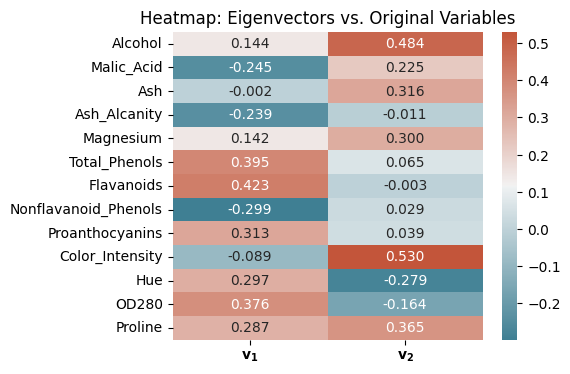

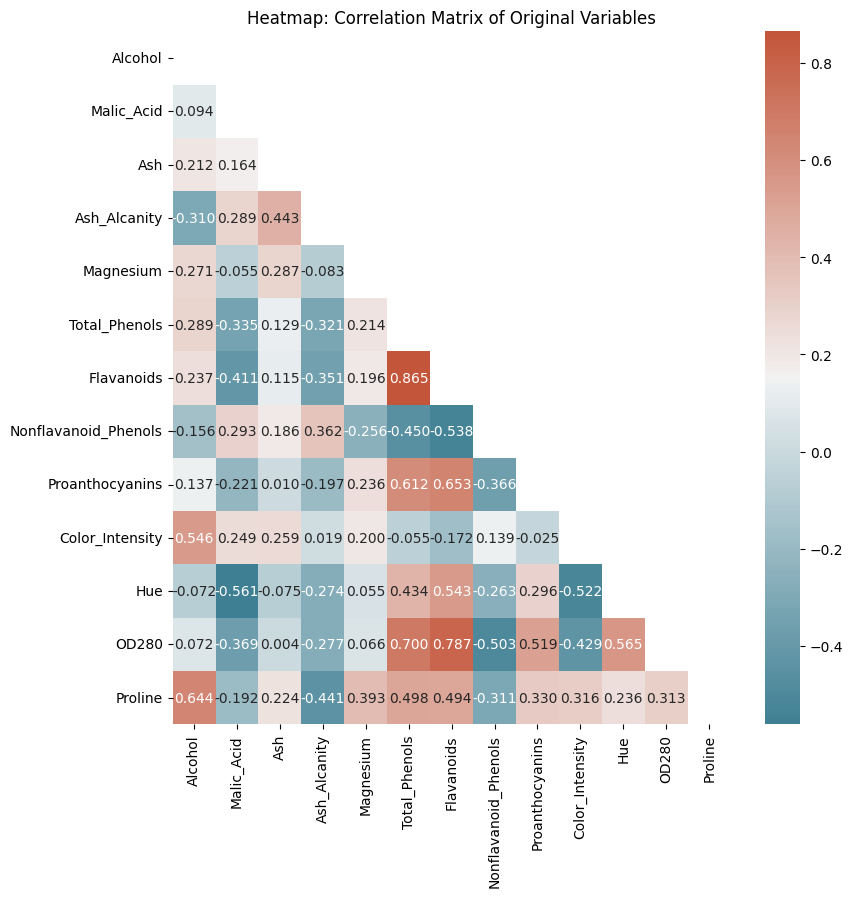

In [90]:
# 繪製特徵向量與原始變數的熱圖
plt.figure(figsize = (5, 4))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(eigenvectors_df, annot = True, cmap = cmap, fmt = ".3f")
plt.title('Heatmap: Eigenvectors vs. Original Variables')
plt.show()

# 原變數間的相關係數熱圖
plt.style.use('default')
plt.figure(figsize = (9, 9))
# 計算相關係數
R = df_wine1.corr()
# np.ones_like(R, dtype = bool): 生成一個和 R 一樣大小的矩陣，元素全為 True
# np.triu(): 上三角矩陣（np.tril 則是下三角矩陣）
mask = np.triu(np.ones_like(R, dtype = bool)) # diagonal mask 
# annot = True: 在 heatmap 上標註相關係數
# mask: 隱藏上三角（或下三角）
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(R, annot = True, mask = mask, cmap = cmap, fmt = ".3f")
plt.title('Heatmap: Correlation Matrix of Original Variables')
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 上圖為前兩個主成分的特徵向量與原變數對應的熱圖（heatmap），下圖則為原變數之間的相關係數熱圖。  

- 在第一主成分的特徵向量中，係數最高的前三個變數為 **Total_Phenols**、**Flavanoids** 和 **OD280**，而係數最低的前三個變數則為 **Nonflavanoid_Phenols**、**Malic_Acid** 和 **Ash_Alcanity**，顯示這些變數對第一主成分的貢獻最大。此外，下圖的相關係數熱圖顯示，**Total_Phenols** 與 **Flavanoids**、**OD280** 之間高度正相關，而與 **Nonflavanoid_Phenols**、**Malic_Acid** 和 **Ash_Alcanity** 則呈高度負相關，這與第 2 小題的觀察結果一致。因此，可以判斷第一主成分的特徵向量係數確實與原變數之間的相關性有直接關聯。  

- 在第二主成分的特徵向量中，係數最高的前三個變數為 **Color_Intensity**、**Alcohol** 和 **Proline**，而係數最低的前三個變數為 **Hue**、**OD280** 和 **Ash_Alcanity**。從相關係數熱圖可見，**Color_Intensity** 與 **Alcohol**、**Proline** 之間高度正相關，而與 **Hue**、**OD280** 呈高度負相關。此外，**Ash_Alcanity** 的線性相關係數僅 **0.019**，與其在第二主成分中的貢獻（-0.011）相符，進一步驗證了第 2 小題的觀察。因此，第二主成分的特徵向量係數同樣與原變數的相關性存在明顯關聯。  

- 綜合來看，第一與第二主成分的特徵向量皆與原變數的相關係數矩陣高度相關，顯示兩者提供了相似的資訊。換言之，透過變數間的相關性可以預測其在主成分分析（PCA）中的影響力，彼此相關程度較高的變數在相同主成分中的權重通常也較大。  

<hr>
<hr>

### **<font color=cornflowerblue>第 2 題：</font>**

資料來自 [NUMBEO](https://www.numbeo.com/quality-of-life/rankings.jsp) 的 2025 年城市生活品質指數（Quality of Life Index by City 2025），包含全球 **263** 座城市的生活品質排名，並包括 **8** 個指標數值。資料檔案可下載：[2025_city_quality.xlsx](https://ntpuccw.blog/wp-content/uploads/2025/02/2025_city_quality.xlsx)。

在此題中，可以將排名資料轉換為代表生活品質的「標籤」（labels），例如：  
- 若總分（欄位 **Quality of Life Index**）大於 **200**，則標記為「高品質」（HIGH），並賦予數字 **3**；  
- 若分數介於 **100 到 200** 之間，則標記為「中品質」（MEDIUM），並賦予數字 **2**；  
- 若總分低於 **100**，則標記為「低品質」（LOW），並賦予數字 **1**。  

##### (1) 匯入資料，觀察資料的基本屬性。

In [12]:
# 路徑
path = r"C:\Users\Sheng\Documents\NTPU_Bachelor\Year_4\Y4_Sem_2\ShallowML\ClassData"
# 讀取資料
df_city_quality = pd.read_excel(path + r'\2025_city_quality.xlsx')

# 以 'Quality of Life Index' 為基準將資料分組，並存入 y
df_city_quality['Group'] = np.where(df_city_quality['Quality of Life Index'] > 200, 3, \
                                np.where(df_city_quality['Quality of Life Index'] > 100, 2, 1))
y = df_city_quality['Group'].values

# 保留需要的 index
vars_need = df_city_quality.columns.tolist()[3:11]
df_city_quality1 = df_city_quality[vars_need].copy()

# 顯示資料特性
# df.info()
print('【樣本數】:', df_city_quality1.shape[0])
print('【欄位數】:', df_city_quality1.shape[1])
print('【群組數】:', len(np.unique(y)))
# 動態生成每群樣本數
unique_groups, group_counts = np.unique(y, return_counts=True)
group_info = ', '.join([f'{group}: {count}' for group, count in zip(unique_groups, group_counts)])
print(f'【每群樣本數】: {group_info}')
display(df_city_quality1.head())

【樣本數】: 263
【欄位數】: 8
【群組數】: 3
【每群樣本數】: 1: 30, 2: 214, 3: 19


,Purchasing Power Index,Safety Index,Health Care Index,Cost of Living Index,Property Price to Income Ratio,Traffic Commute Time Index,Pollution Index,Climate Index
0,151.8,79.5,80.7,58.3,5.7,21.0,17.9,90.6
1,153.5,78.1,76.4,54.5,5.0,20.1,18.8,83.5
2,174.4,71.3,76.3,66.0,8.8,27.5,21.6,82.6
3,140.6,78.4,79.0,59.9,6.4,24.0,19.2,85.4
4,182.4,72.9,71.6,98.0,8.5,27.6,24.9,82.8


<hr>

##### (2) 利用 `seaborn` 套件裡的 `heatmap` 指令繪製出變數間的相關係數圖，以觀察變數間是否存在相關性。

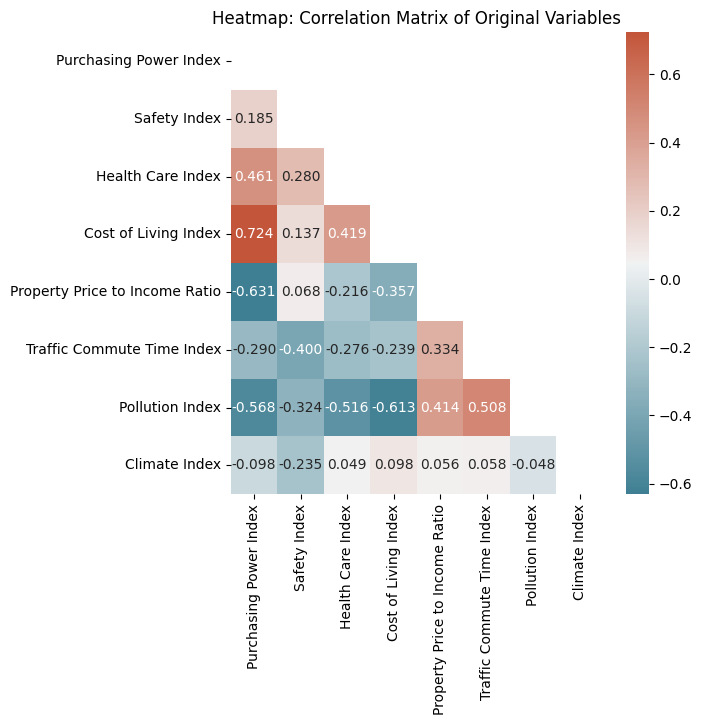

In [127]:
# Plot the correlation matrix
plt.style.use('default')
plt.figure(figsize = (6, 6))
# 計算相關係數
R = df_city_quality1.corr()
# np.ones_like(R, dtype = bool): 生成一個和 R 一樣大小的矩陣，元素全為 True
# np.triu(): 上三角矩陣（np.tril 則是下三角矩陣）
mask = np.triu(np.ones_like(R, dtype = bool)) # diagonal mask 
# annot = True: 在 heatmap 上標註相關係數
# mask: 隱藏上三角（或下三角）
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(R, annot = True, mask = mask, cmap = cmap, fmt = ".3f")
plt.title('Heatmap: Correlation Matrix of Original Variables')
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 上圖呈現的是變數間的相關係數圖。由於相關係數矩陣為對稱矩陣（Symmetric Matrix），因此僅顯示其下三角矩陣（Lower Triangular Matrix）。  

- 從圖中可見，紅色越深代表變數間的正相關性越高，而藍色越深則代表負相關性越高。例如，**Purchasing Power Index** 與 **Cost of Living Index** 及 **Health Care Index** 之間呈現高度正相關，相關係數皆大於 0.4；而與 **Property Price to Income Ratio** 及 **Pollution Index** 則呈現高度負相關，相關係數皆小於 -0.5。  

- 另一個例子是 **Pollution Index** 與 **Property Price to Income Ratio** 及 **Traffic Commute Time Index** 之間存在高度正相關，相關係數皆大於 0.4，而與 **Cost of Living Index** 及 **Purchasing Power Index** 則呈現高度負相關，相關係數皆小於 -0.5。  

- 從相關係數矩陣的觀察結果來看，部分變數之間確實存在較強的相關性，因此可考慮使用主成分分析（PCA）進行降維，以減少變數間的多重共線性並提升分析的效能。

<hr>

##### (3) 繪製一張含有每種生活品質指標（變數）的盒鬚圖（Boxplot），觀察每個變數的數值範圍（Scaling），以作為是否需要標準化的參考。同時，再繪製一張標準化後的盒鬚圖，並與原始資料進行比較。

1）將資料進行標準化

In [13]:
# 將資料進行標準化
columns = df_city_quality1.columns
scaler = StandardScaler()  # create a StandardScaler object
X_std = scaler.fit_transform(df_city_quality1)  # standardize the data
df_X_std = pd.DataFrame(X_std, columns=columns)

2）繪製 boxplot

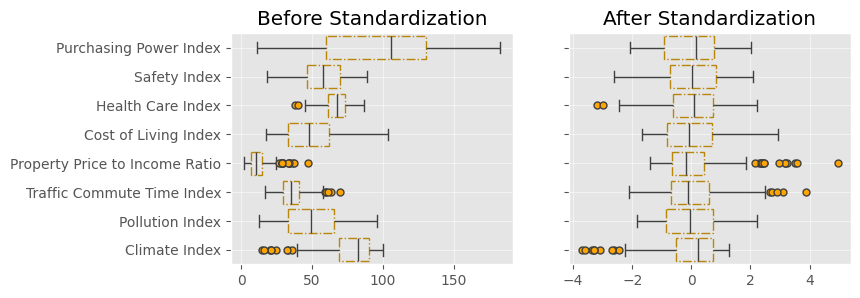

In [14]:
# 繪製 boxplot
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
boxprops = dict(linestyle='-.', linewidth=1, facecolor='none', edgecolor='darkgoldenrod')
flierprops = dict(marker='o', markerfacecolor='orange', markersize=5, linestyle='none')

# 未標準化
sns.boxplot(data=df_city_quality1, ax=ax[0], orient='h', boxprops=boxprops, flierprops=flierprops)
ax[0].grid(True, alpha=0.5)
ax[0].set_title('Before Standardization')

# 標準化
sns.boxplot(data=df_X_std, ax=ax[1], orient='h', boxprops=boxprops, flierprops=flierprops)
ax[1].grid(True, alpha=0.5)
ax[1].set_title('After Standardization')

plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 左圖為原始資料中各生活品質指標的盒鬚圖（Boxplot），而右圖則為標準化後的盒鬚圖。  

- 從左圖可以看出，雖然相較於 **第 1 題** 的資料，各指標的數值範圍並未呈現極端的不一致性，但仍有部分變數的數值範圍明顯長於其他變數，特別是 **Purchasing Power Index**，其數值範圍遠高於其他指標，導致整體資料的縮放尺度（scaling）被拉大。因此，為了避免 **Purchasing Power Index** 在後續分析中產生過大的影響，應對資料進行標準化，以降低潛在的誤差。  

- 右圖顯示標準化後的結果，各指標的數值範圍趨於一致，使後續分析更加穩定，避免因資料縮放尺度的差異而影響結果的準確性。

<hr>

##### (4) 對原始資料與標準化後的資料分別進行主成分分析（PCA），並繪製 Scree Plot（顯示特徵值由大到小的分布）以及 Pareto Plot（顯示每個主成分解釋的變異量比例及其累積變異量比例），觀察標準化是否會影響主成分的分析結果。

1）進行 PCA

In [16]:
# PCA
# 未標準化的資料
pca = PCA()  # create a PCA object
X_pca = pca.fit(df_city_quality1)  # apply PCA to the standardized data
Z = pca.transform(df_city_quality1)  # get the new data matrix Z
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

# 標準化後的資料
pca_std = PCA()  # create a PCA object
X_pca_std = pca_std.fit(X_std)  # apply PCA to the standardized data
Z_std = pca_std.transform(X_std)  # get the new data matrix Z
eigenvalues_std = pca_std.explained_variance_
eigenvectors_std = pca_std.components_

2）繪製 Scree Plot 和 Pareto Plot

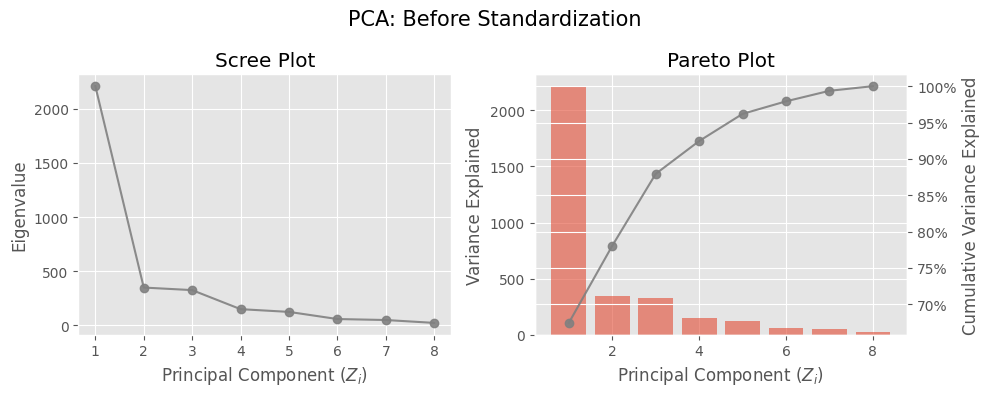

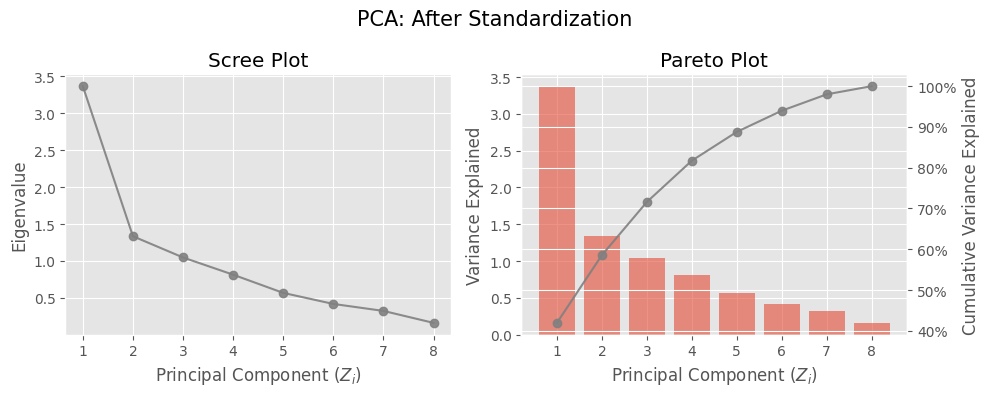

In [17]:
# 繪製 scree plot 和 pareto plot
plt.style.use('ggplot')

def plots(eigenvalues, title):
    # 計算主成分數量
    pca_range = np.arange(1, len(eigenvalues) + 1)
    # 計算解釋變異量
    cum_var_exp = np.cumsum(eigenvalues / eigenvalues.sum()) * 100

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # Scree Plot
    ax[0].plot(pca_range, eigenvalues, 'o-', alpha=0.9, color='gray')
    ax[0].set_title('Scree Plot')
    ax[0].set_xlabel('Principal Component ($Z_i$)')
    ax[0].set_ylabel('Eigenvalue')

    # Pareto Plot
    ax2 = ax[1].twinx()  # 創建共享 x 軸的第二個 y 軸
    ax[1].bar(pca_range, eigenvalues, alpha=0.6, align='center', label='Individual explained variance')
    ax[1].set_title('Pareto Plot')
    ax[1].set_xlabel('Principal Component ($Z_i$)')
    ax[1].set_ylabel('Variance Explained')
    # if title == 'PCA: Original Data':
    #     # 使用 FuncFormatter 來格式化 y 軸標籤，例如1e2
    #     ax[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0e}'.format(x)))
    # 畫出累積解釋變異量，用百分比表示
    ax2.plot(pca_range, cum_var_exp, 'o-', alpha=0.9, color='gray')
    ax2.set_ylabel('Cumulative Variance Explained')
    
    # if title == 'PCA: Original Data':
    #     # 使用 FuncFormatter 來格式化 y 軸標籤
    #     ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1f}%'.format(y)))
    # else:
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()

# 未標準化
plots(eigenvalues, 'PCA: Before Standardization')
# 標準化
plots(eigenvalues_std, 'PCA: After Standardization')

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 上圖為原始資料進行 PCA 後的結果，包含 **Scree Plot**（左上，顯示特徵值的分布）與 **Pareto Plot**（右上，顯示各主成分的變異量比例與累積變異量比例）。下圖則為標準化後資料的對應 PCA 結果，分別為 **Scree Plot**（左下）與 **Pareto Plot**（右下）。  

- 從上圖觀察，雖然 **Scree Plot** 顯示第一與第二主成分的特徵值差距顯著，但與標準化後（下圖）的結果相比，差異並不明顯，因此難以直接判斷標準化對結果的影響。此外，**Pareto Plot** 亦顯示第一主成分解釋的變異量比例遠高於其他主成分，使變異量的分配略顯不均。然而，由於資料的數值範圍並未極端不均，即使未標準化，PCA 結果仍未呈現過度偏倚的現象。因此，若資料的縮放尺度（scaling）差異不大，標準化雖然仍會影響 PCA 結果，使部分主成分的影響被放大或縮小，但影響程度相對有限。  

- 下圖顯示，標準化後的 PCA 結果更加合理，說明標準化後的 PCA 具有較佳的解釋能力。在 **Scree Plot** 中，前兩個主成分的特徵值變化較為陡峭，而從第三主成分開始，下降趨勢趨於穩定；同時，**Pareto Plot** 顯示前三主成分的累積變異量比例已接近 70%，表示這三個主成分已能解釋大部分資料的變異。因此，可判斷取前三個主成分即可有效代表原始資料的結構，並大幅降低維度，減少資訊流失，提升後續分析的效率。  

- 與第 1 題相比，本題的資料數值範圍並不極端不均，因此若未特別檢視標準化的必要性，可能會因為 PCA 結果看起來「尚可接受」而忽略標準化對分析的影響，進而導致後續結果產生誤差。這再次突顯了進行 PCA 前評估資料 scaling 是否需要標準化的重要性。

<hr>

##### (5) 資料中的每座城市都有標籤（df_city_quality 中的 **Group**），表示其生活品質的高低（**3: HIGH, 2: MEDIUM, 1: LOW**）。現在假設不考慮此標籤，先利用主成分分析（PCA）擷取前兩個主成分（$Z_1$ 和 $Z_2$），並繪製其散布圖，觀察該散布圖是否能夠顯示出兩個明顯的群組。請注意：資料是否經過標準化可能會影響結果，試著比較標準化與非標準化情況下的差異。

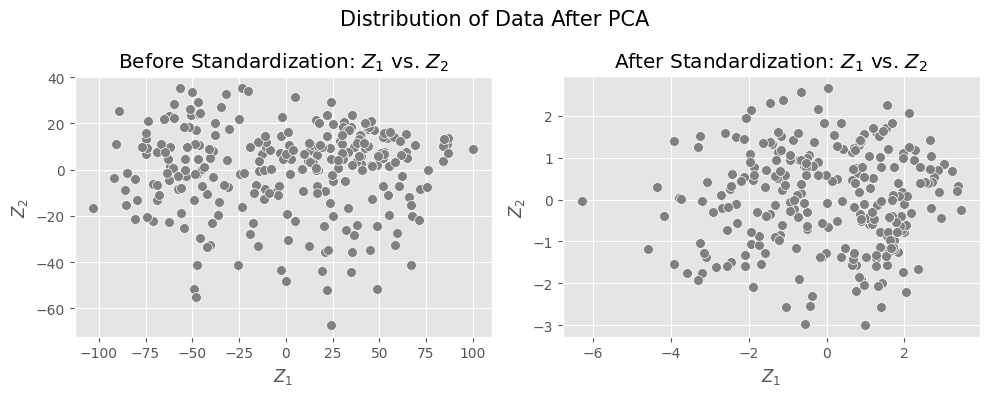

In [18]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(Z[:, 0], Z[:, 1], edgecolors='w', color='gray', s=50)
ax[0].set_xlabel('$Z_1$')
ax[0].set_ylabel('$Z_2$')
ax[0].set_title('Before Standardization: $Z_1$ vs. $Z_2$')

ax[1].scatter(Z_std[:, 0], Z_std[:, 1], edgecolors='w', color='gray', s=50)
ax[1].set_xlabel('$Z_1$')
ax[1].set_ylabel('$Z_2$')
ax[1].set_title('After Standardization: $Z_1$ vs. $Z_2$')

plt.suptitle('Distribution of Data After PCA', fontsize=15)
plt.tight_layout()
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 左圖顯示的是未標準化資料的前兩個主成分散佈圖。可以看出，資料點分布較為分散，沒有明顯的群組區隔，顯示未標準化的資料可能會影響 PCA 的判斷。 

- 右圖為標準化後的前兩個主成分散佈圖。與左圖相比，資料點的分布較為集中，顯示標準化確實影響了 PCA 的結果。然而，即便標準化後，資料點仍未呈現明顯的群組區隔，難以直接從圖中將資料劃分為兩群或多群。  

- 因此，單靠前兩個主成分的散佈圖可能不足以清楚揭示資料的群組分布，或許需考慮更高維度的投影來觀察是否存在明顯的分群現象。

<hr>

##### (6) 根據每筆資料的標籤（已在第 1 小題中存入 **y** 變數），為散布圖上的資料點填上對應的顏色，並觀察其分布是否與前一小題的判斷相符。

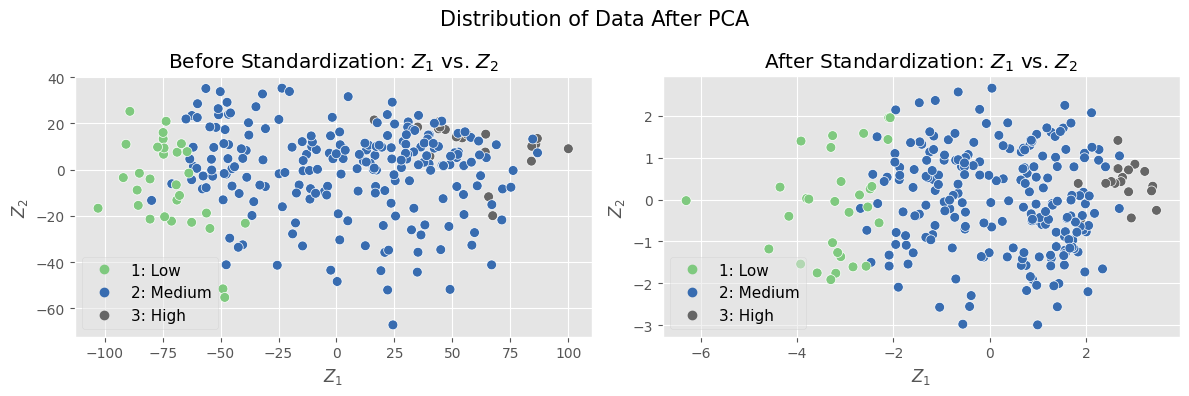

In [19]:
plt.style.use('ggplot')
# 獲取唯一的類別
unique_classes = np.unique(y)
unique_classes_label = ['Low', 'Medium', 'High']

# 創建顏色映射
base_cmap = plt.colormaps['Accent']
cmap = ListedColormap(base_cmap(np.linspace(0, 1, len(unique_classes))))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Before Standardise
scatters = ax[0].scatter(Z[:, 0], Z[:, 1], c=y, edgecolors='w', cmap=cmap, s=50)
ax[0].set_xlabel('$Z_1$')
ax[0].set_ylabel('$Z_2$')
ax[0].set_title('Before Standardization: $Z_1$ vs. $Z_2$')

# 查出 scatters 使用的顏色和對應的類別
colors = cmap(np.linspace(0, 1, len(unique_classes)))
labels = [f'{cls}: {lbl}' for cls, lbl in zip(unique_classes, unique_classes_label)]

# 創建圖例項目
legend_patches = [mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None', markersize=6, 
                                label=labels[i]) for i in range(len(unique_classes))]

# 添加圖例
legend = ax[0].legend(handles=legend_patches, loc='lower left', fontsize=11)
legend.get_frame().set_alpha(0.5)  # 設置圖例框的透明度

# After Standardise
scatters_std = ax[1].scatter(Z_std[:, 0], Z_std[:, 1], c=y, edgecolors='w', cmap=cmap, s=50)
ax[1].set_xlabel('$Z_1$')
ax[1].set_ylabel('$Z_2$')
ax[1].set_title('After Standardization: $Z_1$ vs. $Z_2$')

# 查出 scatters_std 使用的顏色和對應的類別
colors_std = cmap(np.linspace(0, 1, len(unique_classes)))
labels_std = [f'{cls}: {lbl}' for cls, lbl in zip(unique_classes, unique_classes_label)]

# 創建圖例項目
legend_patches_std = [mlines.Line2D([], [], color=colors_std[i], marker='o', linestyle='None', markersize=6, 
                                    label=labels_std[i]) for i in range(len(unique_classes))]

# 添加圖例
legend = ax[1].legend(handles=legend_patches_std, loc='lower left', fontsize=11)
legend.get_frame().set_alpha(0.5)  # 設置圖例框的透明度

plt.suptitle('Distribution of Data After PCA', fontsize=15)
plt.tight_layout()
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 左圖為未標準化資料的前兩個主成分散佈圖。加入標籤後，可以更直觀地觀察到，資料點未形成明確的分群，即使經過 PCA，仍無法有效區分各群組。  

- 右圖為標準化後的前兩個主成分散佈圖。與左圖相比，標籤的加入使群組的輪廓稍微清晰了一些，大部分資料點確實集中在 3 個區域，顯示標準化有助於提升 PCA 在群組辨識上的效果。然而，部分資料點之間仍有重疊，群組邊界不夠明確，說明僅靠前兩個主成分仍無法完全區分各群組。 

- 綜合第 3、4、5、6 小題的結果，可見標準化對 PCA 影響顯著。因此，在執行 PCA 之前，應先檢視資料的數值範圍（scaling），判斷是否需要標準化，以避免後續分析產生誤差。此外，雖然加入標籤後群組的輪廓略為清晰，但邊界仍不夠明確，無法有效區分各群組，這與前一小題的結論一致，說明單靠前兩個主成分的散佈圖不足以達成良好的分群效果。因此，可考慮透過更高維度的投影來觀察是否存在更明顯的群組結構，或重新調整 **第 1 小題** 的分群標準，以獲得更合理的分類結果。

<hr>

##### (7) 從 $Z_1$ 與 $Z_2$ 的散佈圖進一步推敲，也許需要加入 $Z_3$ 才能分得更好，又或許去除 $Z_2$ 僅取 $Z_1$ 也可以分得不錯。請提出你的看法。

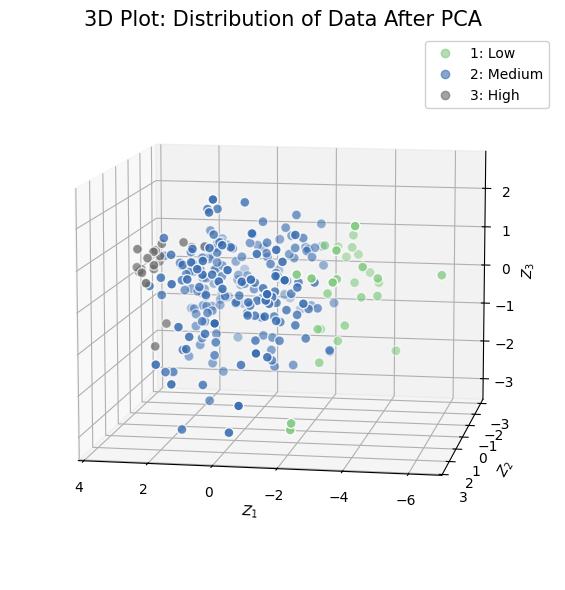

In [99]:
# 獲取唯一的類別
unique_classes = np.unique(y)
unique_classes_label = ['Low', 'Medium', 'High']

# 創建顏色映射
base_cmap = plt.colormaps['Accent']
cmap = ListedColormap(base_cmap(np.linspace(0, 1, len(unique_classes))))

# 改畫立體圖，要利用三個主成分
plt.style.use('default')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(Z_std[:, 0], Z_std[:, 1], Z_std[:, 2], c=y, edgecolors='w', cmap=cmap, s=50)
ax.set_xlabel('$Z_1$')
ax.set_ylabel('$Z_2$')
ax.set_zlabel('$Z_3$')
ax.set_title('3D Plot: Distribution of Data After PCA', fontsize=15)

# 調整觀察角度
ax.view_init(elev=10, azim=100)  # 例如，仰角 40 度，方位角 80 度

# 創建圖例項目
legend_elements, _ = sc.legend_elements(prop="colors", alpha=0.6)
labels = [f'{cls}: {lbl}' for cls, lbl in zip(unique_classes, unique_classes_label)]

# 添加圖例
legend = ax.legend(handles=legend_elements, labels=labels, loc='upper right', fontsize=10)
legend.get_frame().set_alpha(0.9)  # 設置圖例框的透明度

plt.tight_layout()
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 上圖顯示的是標準化後資料的前三個主成分所繪製的三維散佈圖（3D Scatter Plot）。可以看出，相較於二維散佈圖，資料點在三維空間中更容易區分，顯示前三個主成分已能有效描述資料的主要變異，並將大部分資料點劃分清楚。  

- 因此，結合第 4 小題的結論，可判斷至少需使用前三個主成分，才能更完整地展現資料的分群結構。這也進一步驗證了 **Pareto Plot** 中的結果，即前三個主成分的累積變異量比例已達 70%，足以保留資料的主要特徵，確保後續分析的準確性與有效性。

<hr>

##### (8) 觀察並判斷原變數 $X_i$ 與主成分 $Z_i$ 之間的關係： 

主成分 $Z_1$ 和 $Z_2$ 是由原始變數 $X_i$ 的線性組合所形成的新變數。我們可以透過前兩個特徵向量（eigenvectors）的係數，來分析各原變數對於這兩個主成分的貢獻程度，判斷哪些變數影響較大，哪些影響較小。此外，可以繪製特徵向量與原變數對應的熱圖（heatmap），以更直觀地觀察不同變數在各主成分中的權重分布。  

進一步地，若將此結果與第 2 小題的相關係數圖對照，可比較兩者是否提供相似的資訊。例如，若某些變數在相關係數圖中彼此高度相關，它們可能在 PCA 中對相同的主成分具有較高的權重。此題先不考慮理論推導，而僅從圖像觀察與直覺分析，看看是否能發現有趣的模式或趨勢。

1）將 eigenvectors 做資料前處理。

In [100]:
eigenvectors_df = pd.DataFrame(eigenvectors_std[:2], columns = df_city_quality1.columns, \
                               index = ['$\mathbf{v_1}$', '$\mathbf{v_2}$']).T
display(eigenvectors_df)

,$\mathbf{v_1}$,$\mathbf{v_2}$
Purchasing Power Index,0.460364,-0.186476
Safety Index,0.214562,0.673144
Health Care Index,0.360278,0.042708
Cost of Living Index,0.421629,-0.252289
Property Price to Income Ratio,-0.341474,0.288341
Traffic Commute Time Index,-0.326215,-0.335905
Pollution Index,-0.459278,-0.022002
Climate Index,-0.022353,-0.500173


2）繪製特徵向量與原變數對應的熱圖（heatmap），以及第 2 小題原變數之間的相關係數熱圖。

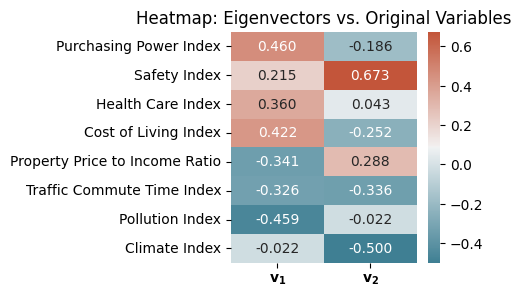

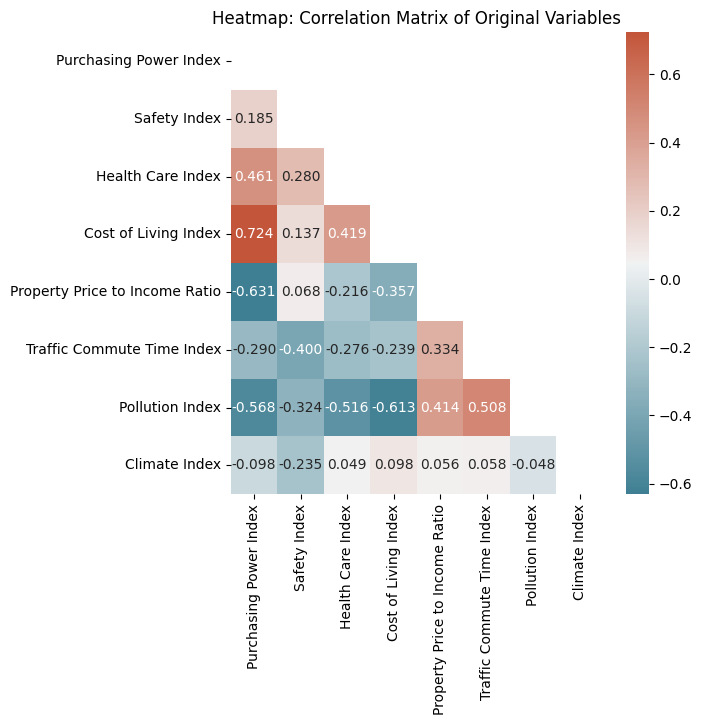

In [101]:
# 繪製特徵向量與原始變數的熱圖
plt.figure(figsize = (3, 3))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(eigenvectors_df, annot = True, cmap = cmap, fmt = ".3f")
plt.title('Heatmap: Eigenvectors vs. Original Variables')
plt.show()

# 原變數間的相關係數熱圖
plt.style.use('default')
plt.figure(figsize = (6, 6))
# 計算相關係數
R = df_city_quality1.corr()
# np.ones_like(R, dtype = bool): 生成一個和 R 一樣大小的矩陣，元素全為 True
# np.triu(): 上三角矩陣（np.tril 則是下三角矩陣）
mask = np.triu(np.ones_like(R, dtype = bool)) # diagonal mask 
# annot = True: 在 heatmap 上標註相關係數
# mask: 隱藏上三角（或下三角）
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(R, annot = True, mask = mask, cmap = cmap, fmt = ".3f")
plt.title('Heatmap: Correlation Matrix of Original Variables')
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 上圖顯示的是前兩個主成分的特徵向量與原變數對應的熱圖（heatmap），而下圖則為原變數之間的相關係數熱圖。  

- 第一主成分的特徵向量顯示，係數最高的前三個變數為 **Purchasing Power Index**、**Cost of Living Index** 和 **Health Care Index**，而係數最低的前三個變數則為 **Pollution Index**、**Property Price to Income Ratio** 和 **Traffic Commute Time Index**。這些變數對第一主成分的影響最大。此外，從相關係數熱圖可見，**Purchasing Power Index** 與 **Cost of Living Index**、**Health Care Index** 之間高度正相關，而與 **Pollution Index**、**Property Price to Income Ratio** 和 **Traffic Commute Time Index** 呈現高度負相關。這與第 2 小題的觀察結果一致，說明第一主成分的特徵向量確實反映了變數之間的相關性。  

- 第二主成分的特徵向量顯示，係數最高的兩個變數為 **Safety Index** 和 **Property Price to Income Ratio**，而係數最低的則為 **Climate Index** 和 **Traffic Commute Time Index**。然而，從相關係數熱圖可見，**Safety Index** 與 **Property Price to Income Ratio** 的相關係數僅為 0.068，顯示它們在原變數空間中幾乎無相關性，這與第一主成分的情況不同。此外，**Climate Index** 與 **Traffic Commute Time Index** 則呈現高度負相關。這種現象表明，儘管主成分特徵向量可以反映變數間的關聯，但 PCA 是基於資料變異來尋找最佳投影方向，因此某些變數即使在主成分空間中有較大貢獻，在原變數空間中未必具有高度相關性。    

- 整體而言，第一與第二主成分的特徵向量與原變數的相關係數矩陣之間存在一定程度的關聯性，顯示兩者所提供的資訊相似。然而，這種關係並非絕對，變數之間的相關性只能作為主成分影響力的參考，而非決定性因素。因此，在進行 PCA 時，除了考慮變數間的相關性外，仍需透過主成分的解釋力與實際應用情境來綜合判斷其代表性。

<hr>
<hr>

### **<font color=cornflowerblue>第 3 題：</font>**

與第 1 題一樣，資料同樣來自 sklearn.datasets 的一組關於乳癌患者腫瘤的影像量測資料。量測變數共 30 個，樣本數為 569 位患者，區分為兩個群組，分別是 Malignant（惡性腫瘤）與 Benign（良性腫瘤）。

資料來源： `sklearn.datasets.load_breast_cancer`

Labels: 0 = 'Malignant', 1 = 'Benign'

##### (1) 匯入資料，觀察資料的基本屬性。

In [20]:
# Load the dataset from sklearn
df_cancer, y = load_breast_cancer(return_X_y=True, as_frame=True)

# 顯示資料特性
# df.info()
print('【樣本數】:', df_cancer.shape[0])
print('【欄位數】:', df_cancer.shape[1])
print('【群組數】:', len(np.unique(y)))
# 動態生成每群樣本數
unique_groups, group_counts = np.unique(y, return_counts=True)
group_info = ', '.join([f'{group}: {count}' for group, count in zip(unique_groups, group_counts)])
print(f'【每群樣本數】: {group_info}')
display(df_cancer.head())

【樣本數】: 569
【欄位數】: 30
【群組數】: 2
【每群樣本數】: 0: 212, 1: 357


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<hr>

##### (2) 利用 `seaborn` 套件裡的 `heatmap` 指令繪製出變數間的相關係數圖，以觀察變數間是否存在相關性。

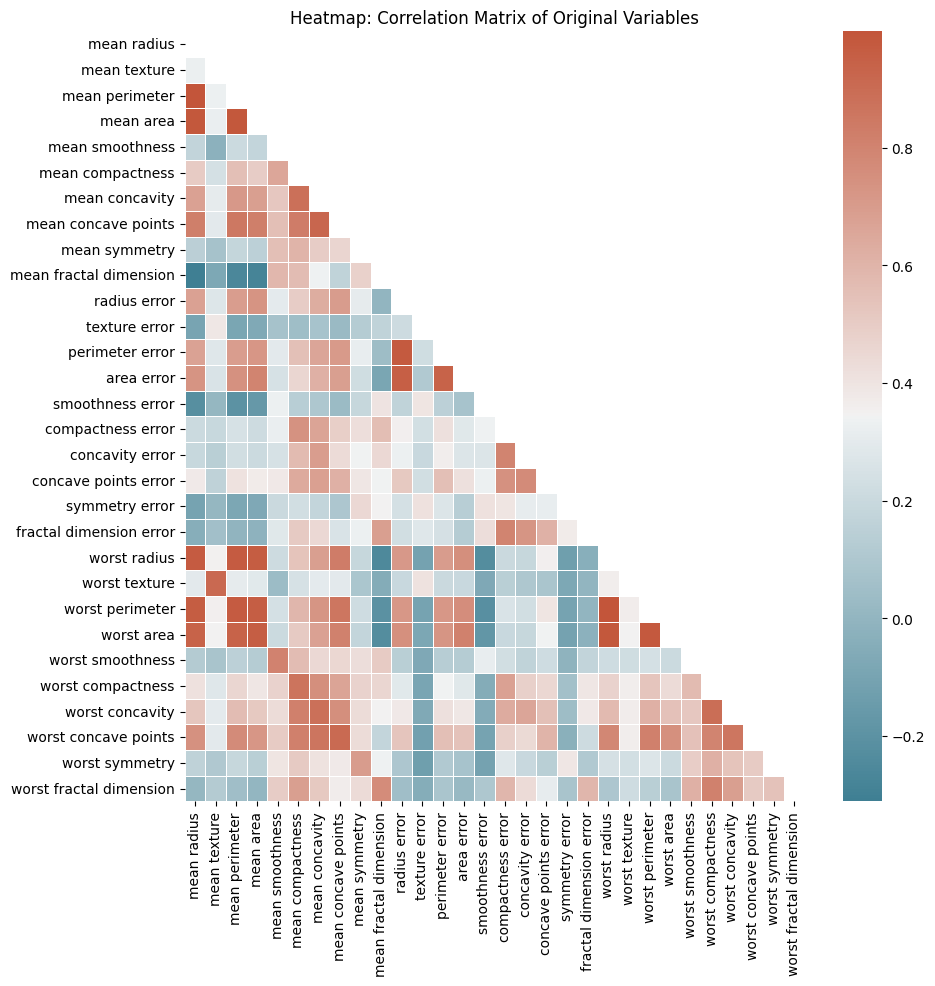

In [ ]:
# Plot the correlation matrix
plt.style.use('default')
plt.figure(figsize = (10, 10))
# 計算相關係數
R = df_cancer.corr()
# np.ones_like(R, dtype = bool): 生成一個和 R 一樣大小的矩陣，元素全為 True
# np.triu(): 上三角矩陣（np.tril 則是下三角矩陣）
mask = np.triu(np.ones_like(R, dtype = bool)) # diagonal mask 
# annot = True: 在 heatmap 上標註相關係數
# mask: 隱藏上三角（或下三角）
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(R, mask = mask, cmap = cmap, annot=False, linewidths=0.7)
plt.title('Heatmap: Correlation Matrix of Original Variables')
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 上圖呈現的是變數間的相關係數圖。由於相關係數矩陣為對稱矩陣（Symmetric Matrix），因此僅顯示其下三角矩陣（Lower Triangular Matrix）。此外，由於資料變數過多，因此不顯示具體相關係數值，改用顏色深淺來表示變數之間的相關程度，且加深係數之間的界線，以便容易區分。

- 從圖中可見，紅色越深代表變數間的正相關性越高，而藍色越深則代表負相關性越高。例如，**mean radius** 與 **mean perimeter**、 **mean area**、 **worst radius**、 **worst perimeter**、 **worst area** 之間呈現高度正相關；而與 **mean fractal dimension** 及 **smoothness error** 則呈現高度負相關。  

- 另一個例子是 **radius error** 與 **perimeter error** 及 **area error** 之間存在高度正相關，而與 **mean fractal dimension** 則呈現高度負相關。  

- 從相關係數矩陣的觀察結果來看，部分變數之間確實存在較強的相關性，因此可考慮使用主成分分析（PCA）進行降維，以減少變數間的多重共線性並提升分析的效能。

<hr>

##### (3) 繪製一張含有每個量測變數的盒鬚圖（Boxplot），觀察每個變數的數值範圍（Scaling），以作為是否需要標準化的參考。同時，再繪製一張標準化後的盒鬚圖，並與原始資料進行比較。

1）將資料進行標準化

In [21]:
# 將資料進行標準化
columns = df_cancer.columns
scaler = StandardScaler()  # create a StandardScaler object
X_std = scaler.fit_transform(df_cancer)  # standardize the data
df_X_std = pd.DataFrame(X_std, columns=columns)

2）繪製 boxplot

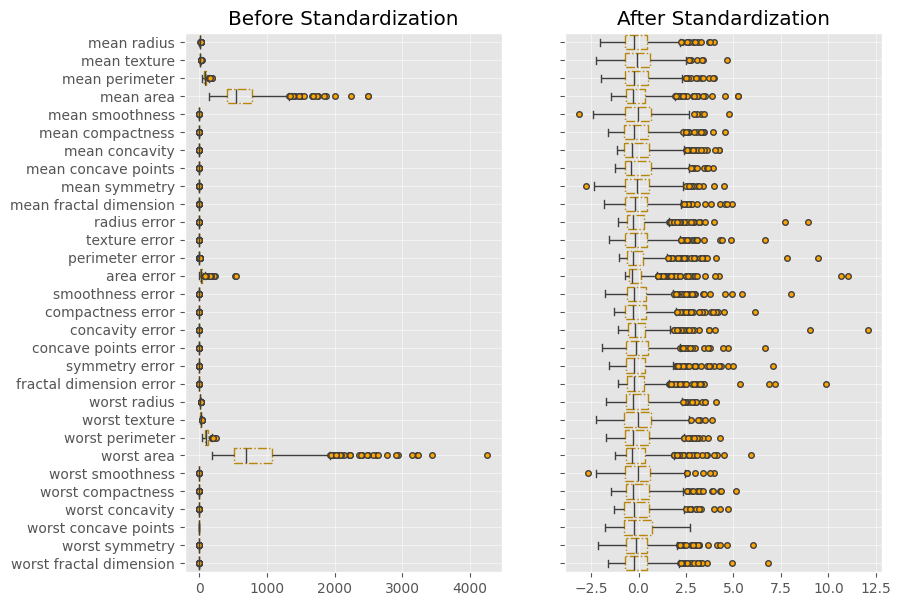

In [22]:
# 繪製 boxplot
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(9, 7), sharey=True)
boxprops = dict(linestyle='-.', linewidth=1, facecolor='none', edgecolor='darkgoldenrod')
flierprops = dict(marker='o', markerfacecolor='orange', markersize=4, linestyle='none')

# 未標準化
sns.boxplot(data=df_cancer, ax=ax[0], orient='h', boxprops=boxprops, flierprops=flierprops)
ax[0].grid(True, alpha=0.5)
ax[0].set_title('Before Standardization')

# 標準化
sns.boxplot(data=df_X_std, ax=ax[1], orient='h', boxprops=boxprops, flierprops=flierprops)
ax[1].grid(True, alpha=0.5)
ax[1].set_title('After Standardization')

plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 左圖顯示的是原始資料中各量測變數的盒鬚圖，而右圖則是標準化後的盒鬚圖。  

- 從左圖可以明顯看出，有兩個量測變數的數值範圍遠高於其他變數，分別是 **mean area** 和 **worst area**，導致整體資料的 scaling 被拉長。因此，為了避免這些變數在後續分析中對結果產生過大影響，應對資料進行標準化，以降低潛在誤差。  

- 標準化後的右圖顯示，各量測變數的數值範圍趨於一致，使後續分析更加穩定，避免因資料 scaling 差異而產生誤差。

<hr>

##### (4) 對原始資料與標準化後的資料分別進行主成分分析（PCA），並繪製 Scree Plot（顯示特徵值由大到小的分布）以及 Pareto Plot（顯示每個主成分解釋的變異量比例及其累積變異量比例），觀察標準化是否會影響主成分的分析結果。

1）進行 PCA

In [23]:
# PCA
# 未標準化的資料
pca = PCA()  # create a PCA object
X_pca = pca.fit(df_cancer)  # apply PCA to the standardized data
Z = pca.transform(df_cancer)  # get the new data matrix Z
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

# 標準化後的資料
pca_std = PCA()  # create a PCA object
X_pca_std = pca_std.fit(X_std)  # apply PCA to the standardized data
Z_std = pca_std.transform(X_std)  # get the new data matrix Z
eigenvalues_std = pca_std.explained_variance_
eigenvectors_std = pca_std.components_

2）繪製 Scree Plot 和 Pareto Plot

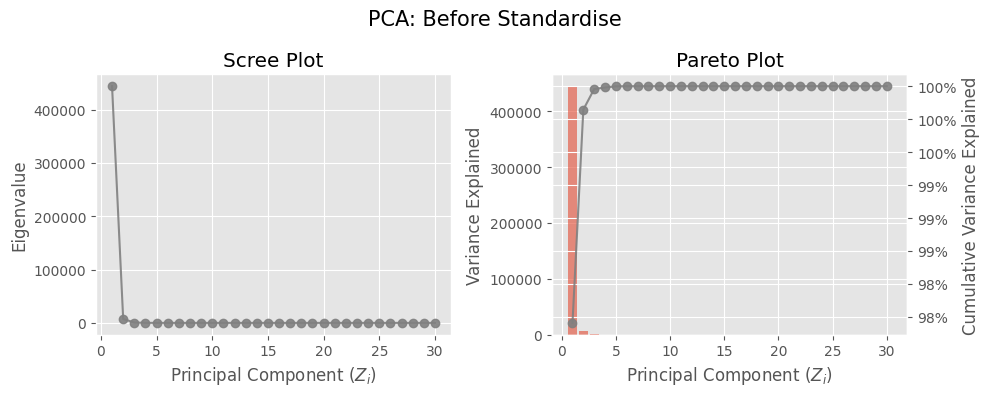

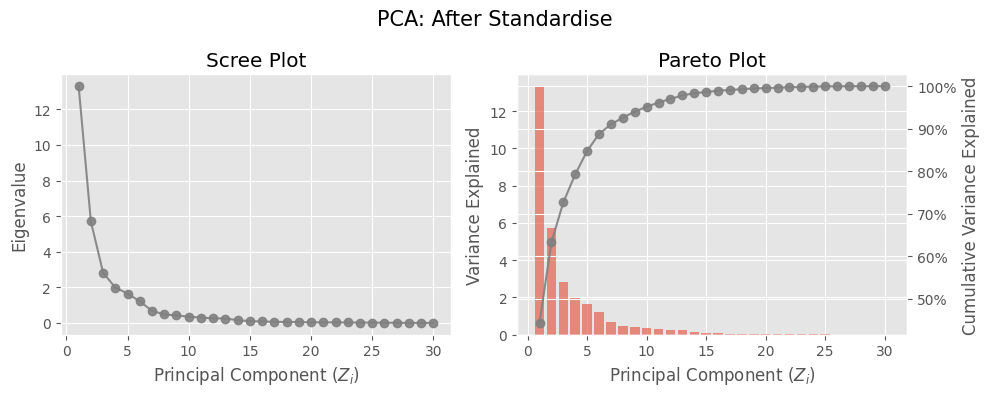

In [24]:
# 繪製 scree plot 和 pareto plot
plt.style.use('ggplot')

def plots(eigenvalues, title):
    # 計算主成分數量
    pca_range = np.arange(1, len(eigenvalues) + 1)
    # 計算解釋變異量
    cum_var_exp = np.cumsum(eigenvalues / eigenvalues.sum()) * 100

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # Scree Plot
    ax[0].plot(pca_range, eigenvalues, 'o-', alpha=0.9, color='gray')
    ax[0].set_title('Scree Plot')
    ax[0].set_xlabel('Principal Component ($Z_i$)')
    ax[0].set_ylabel('Eigenvalue')

    # Pareto Plot
    ax2 = ax[1].twinx()  # 創建共享 x 軸的第二個 y 軸
    ax[1].bar(pca_range, eigenvalues, alpha=0.6, align='center', label='Individual explained variance')
    ax[1].set_title('Pareto Plot')
    ax[1].set_xlabel('Principal Component ($Z_i$)')
    ax[1].set_ylabel('Variance Explained')
    if title == 'PCA: Before Standardization':
        # 使用 FuncFormatter 來格式化 y 軸標籤，例如1e2
        ax[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0e}'.format(x)))
    # 畫出累積解釋變異量，用百分比表示
    ax2.plot(pca_range, cum_var_exp, 'o-', alpha=0.9, color='gray')
    ax2.set_ylabel('Cumulative Variance Explained')
    
    if title == 'PCA: Before Standardization':
        # 使用 FuncFormatter 來格式化 y 軸標籤
        ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1f}%'.format(y)))
    else:
        ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()

# 未標準化
plots(eigenvalues, 'PCA: Before Standardise')
# 標準化
plots(eigenvalues_std, 'PCA: After Standardise')

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 上圖為原始資料進行 PCA 後的結果，其中 **Scree Plot**（左上）顯示特徵值的分布，**Pareto Plot**（右上）則顯示各主成分的變異量比例與累積變異量比例；下圖則為標準化後資料進行 PCA 的對應結果，分別為 **Scree Plot**（左下）與 **Pareto Plot**（右下）。  

- 從上圖可以看出，**Scree Plot** 中第一與第二主成分的特徵值差距顯著，而 **Pareto Plot** 顯示第一主成分解釋的變異量比例遠高於其他主成分，導致變異分配極不均衡，說明未標準化的資料會影響 PCA 的結果，使得部分主成分的影響被放大或縮小。  

- 下圖則顯示標準化後的 PCA 分析結果較為合理，表明標準化後的 PCA 具有較佳的解釋性。在 **Scree Plot** 中，前三個主成分的特徵值變化較為陡峭，而從第四主成分開始趨於平緩；**Pareto Plot** 則顯示前三主成分的累積變異量比例已超過 70%，表示這三個主成分已能解釋大部分資料的變異。因此，可判斷該資料取前三個主成分即可有效代表原始資料的結構，同時大幅降低維度，減少資訊流失並提升後續分析的效率。

<hr>

##### (5) 資料中的每位乳癌患者的腫瘤都有標籤（y），表示腫瘤的成分（Malignant（惡性腫瘤）或 Benign（良性腫瘤））。現在假設不考慮此標籤，先利用主成分分析（PCA）擷取前兩個主成分（$Z_1$ 和 $Z_2$），並繪製其散布圖，觀察該散布圖是否能夠顯示出兩個明顯的群組。請注意：資料是否經過標準化可能會影響結果，試著比較標準化與非標準化情況下的差異。

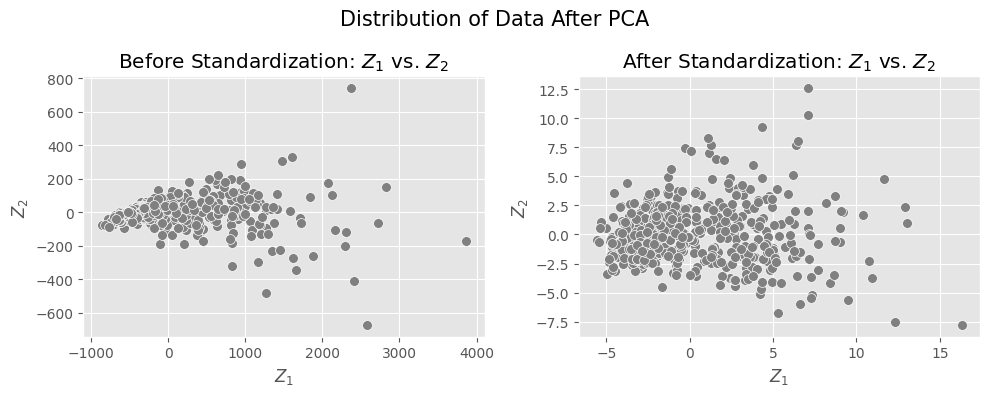

In [25]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(Z[:, 0], Z[:, 1], edgecolors='w', color='gray', s=50)
ax[0].set_xlabel('$Z_1$')
ax[0].set_ylabel('$Z_2$')
ax[0].set_title('Before Standardization: $Z_1$ vs. $Z_2$')

ax[1].scatter(Z_std[:, 0], Z_std[:, 1], edgecolors='w', color='gray', s=50)
ax[1].set_xlabel('$Z_1$')
ax[1].set_ylabel('$Z_2$')
ax[1].set_title('After Standardization: $Z_1$ vs. $Z_2$')

plt.suptitle('Distribution of Data After PCA', fontsize=15)
plt.tight_layout()
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 左圖為未標準化資料的前兩個主成分所繪製的散佈圖，可以看出資料點之間的分布與第 2 題類似，彼此高度集中，沒有明顯的區隔，難以辨識不同群組，顯示未標準化可能會影響 PCA 的判斷。  

- 右圖則為標準化後的前兩個主成分散佈圖，與左圖相比，資料點的分布明顯較為分散，但即使經過標準化，資料仍未呈現明顯的群組區隔，難以直接從圖中區分不同群體。  

- 因此，單憑前兩個主成分的散佈圖可能不足以清楚揭示資料的群組分布，或許需要考慮更高維度的投影，以觀察是否能夠更清楚地展現資料的分群結構。

<hr>

##### (6) 根據每筆資料的標籤（已在第 1 小題中存入 **y** 變數），為散布圖上的資料點填上對應的顏色，並觀察其分布是否與前一小題的判斷相符。

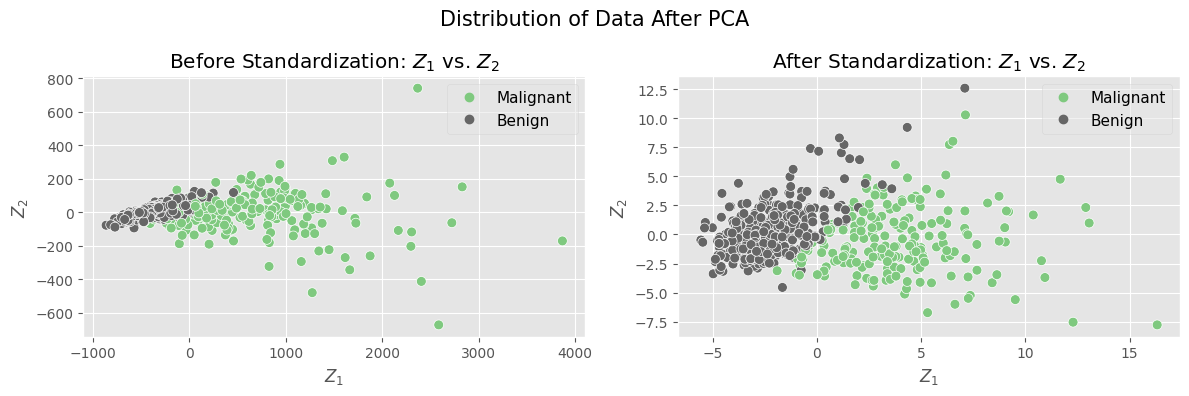

In [26]:
plt.style.use('ggplot')
# 獲取唯一的類別
unique_classes = np.unique(y)

# 創建顏色映射
base_cmap = plt.colormaps['Accent']
cmap = ListedColormap(base_cmap(np.linspace(0, 1, len(unique_classes))))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Before Standardise
scatters = ax[0].scatter(Z[:, 0], Z[:, 1], c=y, edgecolors='w', cmap=cmap, s=50)
ax[0].set_xlabel('$Z_1$')
ax[0].set_ylabel('$Z_2$')
ax[0].set_title('Before Standardization: $Z_1$ vs. $Z_2$')

# 查出 scatters 使用的顏色和對應的類別
colors = cmap(np.linspace(0, 1, len(unique_classes)))
group = ['Malignant', 'Benign']
labels = [f'{gp}' for gp in group]

# 創建圖例項目
legend_patches = [mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None', markersize=6, 
                                label=labels[i]) for i in range(len(unique_classes))]

# 添加圖例
legend = ax[0].legend(handles=legend_patches, loc='upper right', fontsize=11)
legend.get_frame().set_alpha(0.5)  # 設置圖例框的透明度

# After Standardise
scatters_std = ax[1].scatter(Z_std[:, 0], Z_std[:, 1], c=y, edgecolors='w', cmap=cmap, s=50)
ax[1].set_xlabel('$Z_1$')
ax[1].set_ylabel('$Z_2$')
ax[1].set_title('After Standardization: $Z_1$ vs. $Z_2$')

# 查出 scatters_std 使用的顏色和對應的類別
colors_std = cmap(np.linspace(0, 1, len(unique_classes)))
group = ['Malignant', 'Benign']
labels_std = [f'{gp}' for gp in group]

# 創建圖例項目
legend_patches_std = [mlines.Line2D([], [], color=colors_std[i], marker='o', linestyle='None', markersize=6, 
                                    label=labels_std[i]) for i in range(len(unique_classes))]

# 添加圖例
legend = ax[1].legend(handles=legend_patches_std, loc='upper right', fontsize=11)
legend.get_frame().set_alpha(0.5)  # 設置圖例框的透明度

plt.suptitle('Distribution of Data After PCA', fontsize=15)
plt.tight_layout()
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 左圖為未標準化資料的前兩個主成分散布圖。加入標籤後可更直觀地發現資料點似乎呈現出兩個群組的跡象，但群組之間的界線仍然模糊，且大量資料點交疊，無法有效區分，顯示標準化對 PCA 的重要性。  

- 右圖為標準化資料的前兩個主成分散布圖。與左圖相比，資料點的分布不再過度集中，且加入標籤後可以更清楚地看出資料大致分為兩個群組，進一步證明標準化有助於 PCA 進行群組辨識。然而，與左圖相同，群組交界處仍存在部分資料點重疊的現象，顯示僅靠前兩個主成分仍難以完全區分兩個群組。  

- 綜合第 3、4、5、6 小題的結果，可見標準化對 PCA 影響顯著，因此，在執行 PCA 之前，應先檢視資料的數值範圍（scaling），以判斷是否需要標準化，避免分析產生誤差。此外，雖然加入標籤後群組的輪廓變得較為清晰，但邊界仍不夠明確，無法完全區分不同群組，這與前一小題的結論一致，說明單靠前兩個主成分的散布圖不足以達成良好的分群效果，因此可考慮透過更高維度的投影來觀察是否能呈現更明顯的群組結構。

<hr>

##### (7) 當採用三個主成分時，可繪製三維散布圖，以觀察群組的區分效果是否更佳。請嘗試旋轉視角，以獲得最佳辨識效果，並檢視在三維空間中，資料點是否能夠更清楚地分群。

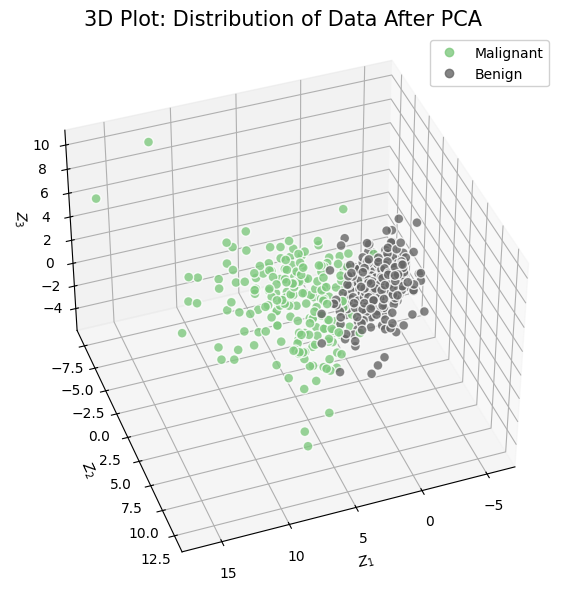

In [ ]:
# 獲取唯一的類別
unique_classes = np.unique(y)

# 創建顏色映射
base_cmap = plt.colormaps['Accent']
cmap = ListedColormap(base_cmap(np.linspace(0, 1, len(unique_classes))))

# 改畫立體圖，要利用三個主成分
plt.style.use('default')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(Z_std[:, 0], Z_std[:, 1], Z_std[:, 2], c=y, edgecolors='w', cmap=cmap, s=50, alpha=0.8)
ax.set_xlabel('$Z_1$')
ax.set_ylabel('$Z_2$')
ax.set_zlabel('$Z_3$')
ax.set_title('3D Plot: Distribution of Data After PCA', fontsize=15)

# 調整觀察角度
ax.view_init(elev=40, azim=70)  # 例如，仰角 40 度，方位角 80 度

# 創建圖例項目
legend_elements, _ = sc.legend_elements(prop="colors", alpha=0.8)
group = ['Malignant', 'Benign']
labels = [f'{gp}' for gp in group]

# 添加圖例
legend = ax.legend(handles=legend_elements, labels=labels, loc='upper right', fontsize=10)
legend.get_frame().set_alpha(0.9)  # 設置圖例框的透明度

plt.tight_layout()
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 上圖為標準化後資料的前三個主成分所繪製的三維散布圖（3D Scatter Plot）。相較於二維散布圖，資料點在三維空間中分布得更為清晰，顯示前三個主成分已能有效描述資料的主要變異，並使大部分資料點得以區分。  

- 綜合第 4 小題的結論，可判斷至少需要前三個主成分，才能更完整地呈現資料的分群結構，這也進一步驗證了 **Pareto Plot** 的結果，即前三個主成分的累積變異量比例已達 70%，足以保留資料的主要特徵，確保後續分析的準確性與有效性。

<hr>

##### (8) 觀察並判斷原變數 $X_i$ 與主成分 $Z_i$ 之間的關係： 

主成分 $Z_1$ 和 $Z_2$ 是由原始變數 $X_i$ 的線性組合所形成的新變數。我們可以透過前兩個特徵向量（eigenvectors）的係數，來分析各原變數對於這兩個主成分的貢獻程度，判斷哪些變數影響較大，哪些影響較小。此外，可以繪製特徵向量與原變數對應的熱圖（heatmap），以更直觀地觀察不同變數在各主成分中的權重分布。  

進一步地，若將此結果與第 2 小題的相關係數圖對照，可比較兩者是否提供相似的資訊。例如，若某些變數在相關係數圖中彼此高度相關，它們可能在 PCA 中對相同的主成分具有較高的權重。此題先不考慮理論推導，而僅從圖像觀察與直覺分析，看看是否能發現有趣的模式或趨勢。

1）將 eigenvectors 做資料前處理。

In [111]:
eigenvectors_df = pd.DataFrame(eigenvectors_std[:2], columns = df_cancer.columns, \
                               index = ['$\mathbf{v_1}$', '$\mathbf{v_2}$'])
display((eigenvectors_df.T))

,$\mathbf{v_1}$,$\mathbf{v_2}$
mean radius,0.218902,-0.233857
mean texture,0.103725,-0.059706
mean perimeter,0.227537,-0.215181
mean area,0.220995,-0.231077
mean smoothness,0.142590,0.186113
mean compactness,0.239285,0.151892
mean concavity,0.258400,0.060165
mean concave points,0.260854,-0.034768
mean symmetry,0.138167,0.190349
mean fractal dimension,0.064363,0.366575


2）繪製特徵向量與原變數對應的熱圖（heatmap），以及第 2 小題原變數之間的相關係數熱圖。

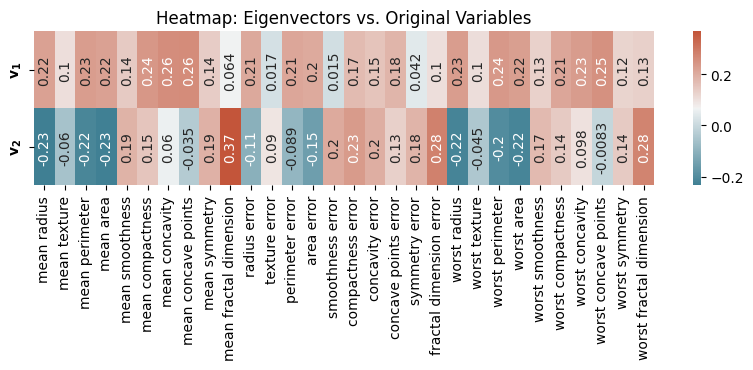

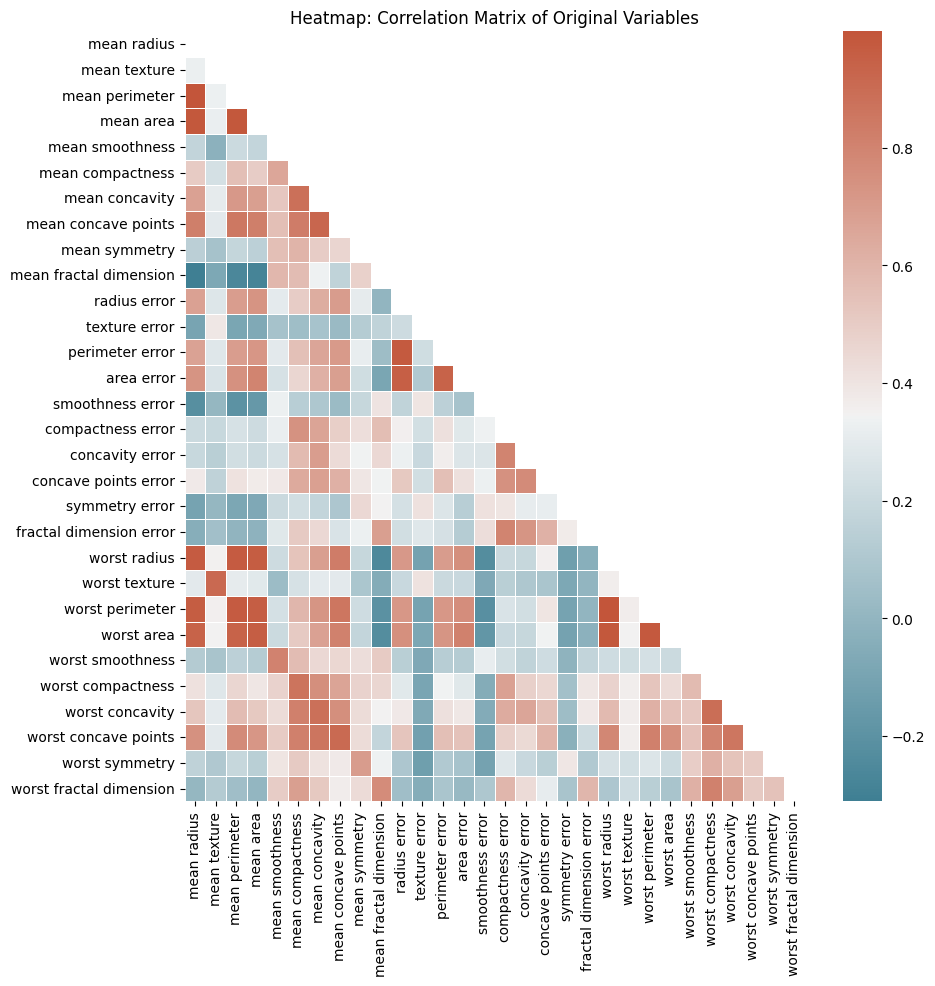

In [112]:
# 繪製特徵向量與原始變數的熱圖
plt.figure(figsize = (10, 2))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(eigenvectors_df, annot = True, cmap = cmap, annot_kws={"rotation": 90})
plt.title('Heatmap: Eigenvectors vs. Original Variables')
plt.show()

# 原變數間的相關係數熱圖
plt.style.use('default')
plt.figure(figsize = (10, 10))
# 計算相關係數
R = df_cancer.corr()
# np.ones_like(R, dtype = bool): 生成一個和 R 一樣大小的矩陣，元素全為 True
# np.triu(): 上三角矩陣（np.tril 則是下三角矩陣）
mask = np.triu(np.ones_like(R, dtype = bool)) # diagonal mask 
# annot = True: 在 heatmap 上標註相關係數
# mask: 隱藏上三角（或下三角）
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(R, mask = mask, cmap = cmap, annot=False, linewidths=0.7)
plt.title('Heatmap: Correlation Matrix of Original Variables')
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 上圖為前兩個主成分的特徵向量與原變數對應的熱圖（heatmap），下圖則為原變數之間的相關係數熱圖。  

- 在第一主成分的特徵向量中，係數最高的三個變數為 **mean concavity**、**mean concave points** 和 **worst concave points**，而係數最低的則為 **mean fractal dimension**、**symmetry error** 和 **texture error**。然而，整體來看，大多數原變數對第一主成分的貢獻程度相近，且沒有特定變數對其產生明顯的主導影響。此外，下圖的相關係數熱圖顯示，**mean concavity** 與 **mean concave points** 及 **worst concave points** 之間具有高度正相關，但與 **mean fractal dimension**、**symmetry error** 和 **texture error** 則幾乎沒有相關性，這與特徵向量的觀察結果相符。因此，可以推測，第一主成分的特徵向量係數與原變數之間的相關性具有一定程度的關聯，但影響並不顯著。  

- 在第二主成分的特徵向量中，係數最高的三個變數為 **mean fractal dimension**、**fractal dimension error** 和 **worst fractal dimension**，而係數最低的則為 **mean radius** 和 **mean area**。從相關係數熱圖可見，**mean fractal dimension** 與 **fractal dimension error** 及 **worst fractal dimension** 之間具有高度正相關，而與 **mean radius** 和 **mean area** 則呈現高度負相關，顯示第二主成分的特徵向量與原變數的相關性較為明顯。  

- 整體而言，第一與第二主成分的特徵向量與原變數的相關係數矩陣之間確實存在一定程度的關聯性，顯示 PCA 所提取的主成分與原變數的內在結構有部分對應。然而，這種關係並非絕對，變數之間的相關性只能作為主成分影響力的參考，而非決定性因素。因此，在進行 PCA 時，除了考量變數間的相關性外，仍需根據主成分的解釋力與實際應用情境，來綜合判斷其代表性與適用性。

<hr>
<hr>